<a href="https://colab.research.google.com/github/kirubarajan/roft/blob/master/annotation/analysis/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Loading and Cleaning

In [326]:
!pip install fsspec gcsfs
!pip install --upgrade spacy

import matplotlib
if matplotlib.__version__ < "3.0":
  !pip install --upgrade matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [327]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import random
import collections
from scipy import stats
import copy
sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette("Set2"))

DATABASE_DUMP_FILE = 'gs://roft_buckups/10-25-21.json'

In [328]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [329]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [330]:
with tf.io.gfile.GFile(DATABASE_DUMP_FILE, 'r') as f:
    lines = f.readlines()
    db = json.loads(lines[1])

def get_df(sql_model='core.annotation'):
    df = pd.DataFrame(db)
    df = df[df.model == sql_model]
    
    if 'date' in df.columns.values:
        df = df.set_index('date')

    return pd.json_normalize(df.fields).assign(pk=df.pk.values)

In [331]:
df = pd.DataFrame(db)
print(set(df["model"].tolist()))

{'core.annotation', 'core.dataset', 'core.decodingstrategy', 'auth.permission', 'core.system', 'core.prompt', 'core.feedbackoption', 'core.generation', 'core.timestamp', 'contenttypes.contenttype', 'core.playlist', 'auth.user', 'admin.logentry', 'sessions.session', 'core.profile'}


### Load all the tables

In [332]:
annotation_df = get_df()
profile_df = get_df('core.profile')
generation_df = get_df('core.generation')
prompt_df = get_df('core.prompt')
playlist_df = get_df('core.playlist')
decodingstrategy_df = get_df('core.decodingstrategy')
user_df = get_df('auth.user')

### Modify column names to avoid duplicates across tables.

In [333]:
prompt_df = prompt_df.rename(columns={"body": "prompt_body"})
generation_df = generation_df.rename(columns={"body": "gen_body"})
decodingstrategy_df = decodingstrategy_df.rename(
    columns={"name": "dec_strat", "value": "dec_strat_value"})
annotation_df["date"] = pd.to_datetime(annotation_df["date"])

### Merge all the relevant tables together.

In [334]:
gen_to_playlist = {}
for idx, row in playlist_df.iterrows():
  shortname = row["shortname"]
  version = row["version"]
  generations = row["generations"]
  for gen_id in generations:
    gen_to_playlist[gen_id] = (shortname, version)

In [335]:
full_df = annotation_df.join(generation_df.set_index('pk'), on='generation')
full_df = full_df.join(prompt_df.set_index('pk'), 'prompt')
full_df = full_df.join(decodingstrategy_df.set_index('pk'), 'decoding_strategy')
full_df = full_df.join(user_df.set_index('pk'), 'annotator')

In [336]:
playlist_names = [] 
playlist_versions = []
for idx, row in full_df.iterrows():
  gen_id = row["generation"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
full_df["playlist_name"] = playlist_names
full_df["playlist_version"] = playlist_versions

##Add survey results to the DataFrame

In [337]:
SURVEY_SPREADSHEET_ID = '1j9-nqsGFhpKSas_z1-IRKORlVbmjTzJ4_u_q6u-hOvg'
KEY = "agreed_to_research"
worksheet = gc.open_by_key(SURVEY_SPREADSHEET_ID).sheet1
rows = worksheet.get_all_values()

survey_df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
full_df = full_df.join(survey_df.set_index('username'), 'username', how="inner")

### Process survey responses
Map the familiarity questions to a 1-5 labeling scheme and process the "major" column to a list of major codes.

In [338]:
def remap_familiarity_labels(x):
  if x == "I've never heard of them.":
    return 1
  elif x == "I've read about them in the news or a blog post.":
    return 2
  elif x == "I’ve been excitedly following them.":
    return 3
  elif x == "I’ve used them before (either with the OpenAI API, HuggingFace Transformers, etc.).":
    return 4
  else:
    return -1

def remap_genre_fam_labels(x):
  if x == "Never":
    return 1
  elif x == "Once to a few times per year":
    return 2
  elif x == "Once to a few times per month":
    return 3
  elif x == "Once to a few times per week":
    return 4
  elif x == "Daily":
    return 5
  else:
    return -1

full_df = full_df.rename(columns={"What did you (or what are you planning to) major/minor in?": "major", 
                                  "How often do you consult a recipe when preparing food?": "recipe_familiarity", 
                                  'How often do you read news from credible news publishers (Philadelphia Inquirer, Wall Street Journal, New York Times, etc.)?':'news_familiarity', 
                                  'How often do you read fiction on the internet (fan fiction, creative writing sub-reddits, ebooks, etc.)?':'stories_familiarity',
                                  'What is your familiarity with GPT-2 and GPT-3?':'gen_familiarity',
                                  'Did you read the RoFT Guide before you tried the game?': 'read_guide',
                                  'Are you a native English speaker?': 'english',
                                  "Do you agree for the data being collected on this form along with any annotations you make on the RoFT website to be used in an anonymized, aggregated way for research on students' ability to detect machine-generated text? Your answer on this question will not affect your grade.": 'agreed_to_research'})

full_df['recipe_familiarity'] = full_df['recipe_familiarity'].apply(remap_genre_fam_labels)
full_df['news_familiarity'] = full_df['news_familiarity'].apply(remap_genre_fam_labels)
full_df['stories_familiarity'] = full_df['stories_familiarity'].apply(remap_genre_fam_labels)
full_df['gen_familiarity'] = full_df['gen_familiarity'].apply(remap_familiarity_labels)

In [339]:
print(full_df.columns)

Index(['date', 'annotator', 'generation', 'playlist', 'boundary', 'points',
       'attention_check', 'reason', 'pk', 'system', 'prompt',
       'decoding_strategy', 'gen_body', 'prompt_body', 'num_sentences',
       'dataset', 'prompt_index', 'dec_strat', 'dec_strat_value', 'password',
       'last_login', 'is_superuser', 'username', 'first_name', 'last_name',
       'email', 'is_staff', 'is_active', 'date_joined', 'groups',
       'user_permissions', 'playlist_name', 'playlist_version', 'Timestamp',
       'Email Address', 'major', 'english', 'recipe_familiarity',
       'news_familiarity', 'stories_familiarity', 'gen_familiarity',
       'read_guide', 'agreed_to_research'],
      dtype='object')


### Process Majors
Parse the free text responses into one of 34 different major codes

In [340]:
#@title Majors
def process_major(x):
  major_labels = []
  CIS = ['Computer and Information Science', 'CIS', 'Computer Science', 'Computer science', 'CS', 'Comp sci', 'computer science', 'cis', 'CSCI']
  MCIT = ['MICT', 'MCIT', 'Computer and Information Technology', 'Information Technology', 'Computer & Information Technology', 'Computer and information tech', 'mcit', 'OMCIT', 'Computer and Information Tech', 'Computer Information and Technology', 'Computer Information Technology', 'Computer and Info Tech', 'CIT', 'computer information technology', 'Computer Science and information Technology', 'cit']
  FIN = ['Finance', 'finance', 'Business Analytics']
  ACCT = ['accounting', 'Accounting']
  BA = ['Business Administration']
  QM = ['quantitative methods']
  CMPE = ['Computer Engineering']
  PHYS = ['Physics', 'physics']
  COM = ['Communications', 'communications']
  COG = ['cognitive science', 'Cognitive Science']
  CBIO = ['Computational Biology']
  ROBO = ['ROBO', 'Robotics']
  LING = ['Linguistics', 'LING']
  EE = ['Environmental Engineering']
  ESE = ['ESE', 'electrical engineering', 'EE']
  NETS = ['NETS', 'Networked and Social Systems Engineering', 'Systems Engineering']
  DATS = ['Data Science', 'data science', 'DATS']
  BIO = ['Biology', 'biology']
  ARTH = ['Art History']
  HIST = ['History', 'history', 'HIST']
  PHIL = ['Philosophy']
  ENT = ['Entrepreneurship']
  DMD = ['DMD', 'Digital Media Design']
  MATH = ['MATH', 'math', 'mathematics', 'Mathematics']
  MED = ['medicine']
  NEURO = ['neuroscience', 'Neuroscience']
  BE = ['BE', 'bioengineering', 'Bioengineering']
  CBE = ['Chemical Engineering']
  CIV = ['civil engineering', 'Civil Engineer']
  MEAM = ['MEAM', 'mechanical engineering', 'Mechanical Engineering']
  ECON = ['Economics', 'ECON']
  CGGT = ['CGGT', 'Computer Graphics and Game Technology']
  SCMP = ['Scientific Computing']

  if any(substring in x for substring in CIS):
    major_labels.append("CIS")
  if any(substring in x for substring in MCIT):
    major_labels.append("MCIT")
  if any(substring in x for substring in FIN):
    major_labels.append("FIN")
  if any(substring in x for substring in ACCT):
    major_labels.append("ACCT")
  if any(substring in x for substring in BA):
    major_labels.append("BA")
  if any(substring in x for substring in QM):
    major_labels.append("QM")
  if any(substring in x for substring in PHYS):
    major_labels.append("PHYS")
  if any(substring in x for substring in COM):
    major_labels.append("COM")
  if any(substring in x for substring in COG):
    major_labels.append("COG")
  if any(substring in x for substring in CBIO):
    major_labels.append("CBIO")
  if any(substring in x for substring in ROBO):
    major_labels.append("ROBO")
  if any(substring in x for substring in LING):
    major_labels.append("LING")
  if any(substring in x for substring in EE):
    major_labels.append("EE")
  if any(substring in x for substring in ESE):
    major_labels.append("ESE")
  if any(substring in x for substring in NETS):
    major_labels.append("NETS")
  if any(substring in x for substring in DATS):
    major_labels.append("DATS")
  if any(substring in x for substring in BIO):
    major_labels.append("BIO")
  if any(substring in x for substring in ARTH):
    major_labels.append("ARTH")
  if any(substring in x for substring in HIST):
    major_labels.append("HIST")
  if any(substring in x for substring in PHIL):
    major_labels.append("PHIL")
  if any(substring in x for substring in ENT):
    major_labels.append("ENT")
  if any(substring in x for substring in DMD):
    major_labels.append("DMD")
  if any(substring in x for substring in MATH):
    major_labels.append("MATH")
  if any(substring in x for substring in MED):
    major_labels.append("MED")
  if any(substring in x for substring in NEURO):
    major_labels.append("NEURO")
  if any(substring in x for substring in BE):
    major_labels.append("BE")
  if any(substring in x for substring in CIV):
    major_labels.append("CIV")
  if any(substring in x for substring in MEAM):
    major_labels.append("MEAM")
  if any(substring in x for substring in ECON):
    major_labels.append("ECON")
  if any(substring in x for substring in CGGT):
    major_labels.append("CGGT")
  if any(substring in x for substring in CMPE):
    major_labels.append("CMPE")
  if any(substring in x for substring in CBE):
    major_labels.append("CBE")
  if any(substring in x for substring in SCMP):
    major_labels.append("SCMP")

  if x == 'Engineering':
    major_labels.append("ENG")
  if x == 'Computer':
    major_labels.append("MCIT")
  if x == 'AI':
    major_labels.append("AI")
  if x == 'urban planning':
    major_labels.append('URB')
  if x == 'Stories':
    major_labels.append('STOR')

  return major_labels

full_df['major'] = full_df['major'].apply(process_major)

In [341]:
full_df

date  annotator  generation playlist  \
112   2021-08-31 17:11:39.095000+00:00       1666       22877       -1   
114   2021-08-31 17:12:40.795000+00:00       1666       21386       -1   
9158  2021-09-06 21:54:48.912000+00:00       1666       26444        8   
9159  2021-09-06 21:55:07.069000+00:00       1666       26089        8   
9160  2021-09-06 21:56:15.196000+00:00       1666       21338        8   
...                                ...        ...         ...      ...   
46713 2021-10-16 03:29:00.014000+00:00       5582       23987       -1   
46715 2021-10-16 03:29:12.395000+00:00       5582        3577       -1   
46717 2021-10-16 03:29:24.484000+00:00       5582       13990       -1   
46731 2021-10-16 03:31:04.475000+00:00       5582         443       -1   
46739 2021-10-16 03:32:11.892000+00:00       5582        5959       -1   

       boundary  points  attention_check                 reason     pk  \
112           0       0            False  [9123971792800820313]    113   
114           9       5            False                     []    115   
9158          8       5            False           [irrelevant]   9161   
9159          0       0            False           [irrelevant]   9162   
9160          9       5            False                     []   9163   
...         ...     ...              ...                    ...    ...   
46713         9       0            False                     []  51203   
46715         9       0            False                     []  51205   
46717         9       0            False                     []  51207   
46731         3       4            False              [grammar]  51221   
46739         5       2            False              [grammar]  51229   

          system  ...            Timestamp            Email Address   major  \
112    finetuned  ...    9/6/2021 18:14:26  mcolombo@seas.upenn.edu  [NETS]   
114      gpt2-xl  ...    9/6/2021 18:14:26  mcolombo@seas.upenn.edu  [NETS]   
9158   finetuned  ...    9/6/2021 18:14:26  mcolombo@seas.upenn.edu  [NETS]   
9159   finetuned  ...    9/6/2021 18:14:26  mcolombo@seas.upenn.edu  [NETS]   
9160     gpt2-xl  ...    9/6/2021 18:14:26  mcolombo@seas.upenn.edu  [NETS]   
...          ...  ...                  ...                      ...     ...   
46713  finetuned  ...  10/15/2021 23:25:15   irisyin@seas.upenn.edu    [EE]   
46715       gpt2  ...  10/15/2021 23:25:15   irisyin@seas.upenn.edu    [EE]   
46717    gpt2-xl  ...  10/15/2021 23:25:15   irisyin@seas.upenn.edu    [EE]   
46731       gpt2  ...  10/15/2021 23:25:15   irisyin@seas.upenn.edu    [EE]   
46739    gpt2-xl  ...  10/15/2021 23:25:15   irisyin@seas.upenn.edu    [EE]   

      english  recipe_familiarity  news_familiarity  stories_familiarity  \
112       Yes                   2                 3                    5   
114       Yes                   2                 3                    5   
9158      Yes                   2                 3                    5   
9159      Yes                   2                 3                    5   
9160      Yes                   2                 3                    5   
...       ...                 ...               ...                  ...   
46713      No                   4                 4                    4   
46715      No                   4                 4                    4   
46717      No                   4                 4                    4   
46731      No                   4                 4                    4   
46739      No                   4                 4                    4   

      gen_familiarity  read_guide agreed_to_research  
112                 2                            Yes  
114                 2                            Yes  
9158                2                            Yes  
9159                2                            Yes  
9160                2                            Yes  
...               ...         ...                ...  
46713    

## Filtering

### Filter out annotations not part of Version 2

In [342]:
full_df = full_df[full_df.apply(lambda row: row["playlist_version"]=="0.2", axis=1)]

In [343]:
original_df = copy.deepcopy(full_df)

### Filter out unacceptable users
Methods for filtering out annotations for users who have NOT agreed to have their data analyzed (and filtering out us).

**TO HAVE YOUR PROFILE FILTERED OUT, PLEASE FILL OUT THE GOOGLE FORM AND SPECIFY "NO" TO THE QUESTION ABOUT WHETHER YOU WANT TO PARTICIPATE IN RESEARCH.**

In [344]:
# Filter all of the data frames that we use for analysis.
full_df = full_df[full_df['agreed_to_research'] == 'Yes']
annotation_df = annotation_df[annotation_df.annotator.isin(full_df['username'])]

### Filter out annotators we don't like.
ID 4334 used exploits and other scripts to manipulate the site.

In [345]:
full_df = full_df[~full_df['annotator'].isin([4334])]

### Filter out the extra all-human examples from Recipes

In [346]:
import random
import collections
recipe_frequencies = collections.Counter(full_df[full_df["playlist_name"]=="Recipes"]["num_sentences"])
print(recipe_frequencies)
avg_freq_non_final = int(np.round(np.mean([recipe_frequencies[i] for i in range(10)])))
print(avg_freq_non_final)

random.seed(2342)
def filter_fn(row):
  if (row["playlist_name"] == "Recipes") and (row["num_sentences"] == 10):
    return random.random() < (avg_freq_non_final / recipe_frequencies[10])
  else:
    return True
full_df = full_df[full_df.apply(filter_fn, axis=1)]
recipe_frequencies = collections.Counter(full_df[full_df["playlist_name"]=="Recipes"]["num_sentences"])
print(recipe_frequencies)

Counter({10: 3094, 1: 1254, 3: 1216, 2: 1123, 4: 1103, 6: 1088, 5: 1084, 7: 770, 8: 716, 9: 704})
906
Counter({1: 1254, 3: 1216, 2: 1123, 4: 1103, 6: 1088, 5: 1084, 10: 895, 7: 770, 8: 716, 9: 704})


In [347]:
foo = collections.Counter(full_df[full_df["playlist_name"]=="Recipes"]["num_sentences"])
[print(i, foo[i]) for i in range(1,11)]

1 1254
2 1123
3 1216
4 1103
5 1084
6 1088
7 770
8 716
9 704
10 895


[None, None, None, None, None, None, None, None, None, None]

## Cleaning up columns
Rename columns and delete unused columns

In [348]:
pre_cleaning_full_df = copy.deepcopy(full_df)

In [349]:
def clean_up_columns(df):

  columns_to_drop = ['attention_check', 'dec_strat', 'password', 'last_login', 'is_superuser', 'is_staff', 'first_name', 'last_name', 'email', 'is_active', 'groups', 'user_permissions', 'playlist_version', 'agreed_to_research', 'dataset', 'decoding_strategy']
  df = df.drop(columns_to_drop, axis=1)

  df = df.rename(columns={'system':'model','playlist_name':'dataset', 'boundary':'predicted_boundary_index', 'num_sentences':'true_boundary_index'})
  df['true_boundary_index'] = df['true_boundary_index'] - 1
  return df
  
full_df = clean_up_columns(full_df)
original_df = clean_up_columns(original_df)

###Filter out all spans of 5 annotations that were the same exact value:

In [350]:
def is_percentage(annotations, percentage):
  counter = collections.Counter(annotations)
  percent_list = [(counter[i] / len(annotations)) >= percentage for i in range(10)]
  return any(percent_list)

def sliding_window(df, annotator, percentage, n):
  # This function returns all indices where any window of length n +/- that index is over percentage
  # amount a single value
  indices_to_remove = set()
  ann_list = df[df["annotator"] == annotator].sort_values("date")["predicted_boundary_index"]
  if len(ann_list) < n: 
    return set()
  for i in range(len(ann_list) - n):
    if is_percentage(ann_list[i:i+n], percentage):
      indices_to_remove = indices_to_remove.union(set(ann_list[i:i+n].index.tolist()))
  if len(indices_to_remove) > 0:
    print(annotator)
  return indices_to_remove

annotators = set(full_df["annotator"].tolist())
indices_to_remove = set()
for a in annotators:
  indices_to_remove = indices_to_remove.union(sliding_window(full_df, a, 1, 5))

print("Total number of annotations in the data: " + str(len(full_df)))
print("Number of Annotations kept: " + str(len(full_df[~full_df.index.isin(indices_to_remove)])))
print("Number of Annotations removed: " + str(len(indices_to_remove)))
print(len(annotators))

full_df = full_df[~full_df.index.isin(indices_to_remove)]

4627
5141
4630
4641
4644
5157
5160
2089
5178
4678
5204
4729
2171
2683
4786
1720
2247
4810
2764
4828
2271
5345
5349
4331
2802
5368
5377
4361
4363
2316
4364
4365
4368
4884
4383
4388
5411
5417
1838
1849
4415
4420
4934
4433
4440
4950
4444
4446
1894
5483
1903
4976
4467
4982
4474
5006
5021
4514
5540
4548
2024
Total number of annotations in the data: 25340
Number of Annotations kept: 21646
Number of Annotations removed: 3694
241


In [351]:
full_df = full_df[~full_df.index.isin(indices_to_remove)]

## Recover CTRL Labels
In our original analysis we lost the distinction between when a speech was generated with control code and without a control code. This bit of code recovers that information.

In [352]:
CTRL_GEN_FILES_NOCODE = ['gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-dev.json', 
                                                         'gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-train.json', 
                                                         'gs://roft_datasets/generations_v3/speeches/generations-ctrl-nocode-speeches-test.json']
CTRL_GEN_FILES_CODE = ['gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-dev.json', 
                                                   'gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-train.json', 
                                                   'gs://roft_datasets/generations_v3/speeches/generations-ctrl-Politics-speeches-test.json']

reverse_lookup_dict = dict()
for fname in CTRL_GEN_FILES_CODE:
  with tf.io.gfile.GFile(fname, 'r') as f:
    gen_data = json.load(f)
    for gen in gen_data['generations']:
      # Insert the first generated sentence into the dictionary as key. 
      # Value is a boolean. True = generation was made w/ Politics control code
      # Reasoning for try block is in the case of all-human examples
      try: reverse_lookup_dict[gen['generation'][0]] = True
      except IndexError: pass

for fname in CTRL_GEN_FILES_NOCODE:
  with tf.io.gfile.GFile(fname, 'r') as f:
    gen_data = json.load(f)
    for gen in gen_data['generations']:
      # Insert the first generated sentence into the dictionary as key. 
      # Value is a boolean. True = generation was made w/ Politics control code
      try: reverse_lookup_dict[gen['generation'][0]] = False
      except IndexError: pass

print(reverse_lookup_dict)

{'This is a great opportunity for me as your Vice President.': True, 'The Almighty has given us a country for our use as long as we shall live in it': True, 'I have just returned from a trip that took me around the world.   ': True, 'In these two nations we are privileged to meet with representatives who represent some 30 million people -- one third of our total population.': True, 'In this new situation we are placed between two hostile powers.': False, 'But today there are two things which make this occasion particularly solemn.': True, 'The acts of Congress relating thereto, however, have been, from time to time, renewed with varying modifications in each of these States.   ': True, 'We have seen how difficult it can be to recover from natural disasters.': True, 'He began his speech with these words:   "Mr. Speaker: At this time, it is more important than ever before to make sure we are working together toward an American foreign policy which will bring peace and prosperity to all p

In [353]:
# Use the reverse lookup dict to reassign labels for the CTRL generations
# (If all human then randomly assign to either)
def reassign_ctrl_label(x):
  new_model_label = x['model']
  if x['model'] == 'ctrl':
    if x['gen_body']:
      if reverse_lookup_dict[x['gen_body'].split('_SEP_')[0]]:
        new_model_label = 'ctrl-Politics'
      else:
        new_model_label = 'ctrl-nocode'
    else:
      if random.random() > 0.5:
        new_model_label = 'ctrl-Politics'
      else:
        new_model_label = 'ctrl-nocode'
  return new_model_label

random.seed(42)
full_df['model'] = full_df.apply(reassign_ctrl_label, axis=1)

## Replace all human examples with 'human' model

So that the all human examples do not interfere with our analysis

In [354]:
def reassign_all_human_model(x):
  if x['gen_body']:
    return x['model']
  else:
    return 'human'

full_df['model'] = full_df.apply(reassign_all_human_model, axis=1)

# Helper Functions

In [355]:
import scipy.stats

# def mean_confidence_interval(data, confidence=0.99):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return round(m, 3), round(m-h, 3), round(m+h, 3)

def mean_confidence_interval_me(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    left, right = scipy.stats.norm.interval(alpha=confidence,loc=m, scale=se)
    return round(left - m, 5), round(right - m, 5)

def map_playlist_name(playlist):
  """Converts playlist names to the ones we want to use in the paper."""
  if playlist == 'New York Times':
    return "News"
  elif playlist == 'Presidential Speeches':
    return "Speeches"
  elif playlist == 'Recipes':
    return "Recipes"
  elif playlist == 'Short Stories':
    return "Stories"

def map_p_value(x):
  "Converts float p values to the naames we want to use in the paper."""
  if x >= 0:
    return "$p={}$".format(x)
  else:
    return "sanity"

def save(filename):
  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

def find_frequent_annotators(df, min_n=10):
  """Retrieve a list of annotators who have done a minimum number of annotations."""
  
  annotators = []

  for annotator in set(df["annotator"].tolist()):
    points = df[df["annotator"] == annotator]["points"].tolist()
    
    if len(points) >= min_n:
      annotators.append(annotator)

  return annotators

freq20_annotators = find_frequent_annotators(full_df, 20)
full_df_freq20 = full_df[full_df["annotator"].isin(freq20_annotators)]

freq10_annotators = find_frequent_annotators(full_df, 10)
full_df_freq10 = full_df[full_df["annotator"].isin(freq10_annotators)]

# Dataset Statistics

## Counts

In [356]:
full_df.groupby('dataset').count()

date  annotator  generation  playlist  \
dataset                                                        
New York Times         4488       4488        4488      4488   
Presidential Speeches  4835       4835        4835      4835   
Recipes                7709       7709        7709      7709   
Short Stories          4614       4614        4614      4614   

                       predicted_boundary_index  points  reason    pk  model  \
dataset                                                                        
New York Times                             4488    4488    4488  4488   4488   
Presidential Speeches                      4835    4835    4835  4835   4835   
Recipes                                    7709    7709    7709  7709   7709   
Short Stories                              4614    4614    4614  4614   4614   

                       prompt  ...  date_joined  Timestamp  Email Address  \
dataset                        ...                                          
New York Times           4488  ...         4488       4488           4488   
Presidential Speeches    4835  ...         4835       4835           4835   
Recipes                  7709  ...         7709       7709           7709   
Short Stories            4614  ...         4614       4614           4614   

                       major  english  recipe_familiarity  news_familiarity  \
dataset                                                                       
New York Times          4488     4488                4488              4488   
Presidential Speeches   4835     4835                4835              4835   
Recipes                 7709     7709                7709              7709   
Short Stories           4614     4614                4614              4614   

                       stories_familiarity  gen_familiarity  read_guide  
dataset                                                                  
New York Times                        4488             4488        4488  
Presidential Speeches                 4835             4835        4835  
Recipes                               7709             7709        7709  
Short Stories                         4614             4614        4614  

[4 rows x 26 columns]

In [357]:
original_df.groupby('dataset').count()

date  annotator  generation  playlist  \
dataset                                                         
New York Times          5216       5216        5216      5216   
Presidential Speeches   5856       5856        5856      5856   
Recipes                14142      14142       14142     14142   
Short Stories           5766       5766        5766      5766   

                       predicted_boundary_index  points  reason     pk  model  \
dataset                                                                         
New York Times                             5216    5216    5216   5216   5216   
Presidential Speeches                      5856    5856    5856   5856   5856   
Recipes                                   14142   14142   14142  14142  14142   
Short Stories                              5766    5766    5766   5766   5766   

                       prompt  ...  date_joined  Timestamp  Email Address  \
dataset                        ...                                          
New York Times           5216  ...         5216       5216           5216   
Presidential Speeches    5856  ...         5856       5856           5856   
Recipes                 14142  ...        14142      14142          14142   
Short Stories            5766  ...         5766       5766           5766   

                       major  english  recipe_familiarity  news_familiarity  \
dataset                                                                       
New York Times          5216     5216                5216              5216   
Presidential Speeches   5856     5856                5856              5856   
Recipes                14142    14142               14142             14142   
Short Stories           5766     5766                5766              5766   

                       stories_familiarity  gen_familiarity  read_guide  
dataset                                                                  
New York Times                        5216             5216        5216  
Presidential Speeches                 5856             5856        5856  
Recipes                              14142            14142       14142  
Short Stories                         5766             5766        5766  

[4 rows x 26 columns]

## Decoding Strategies

In [358]:
df = full_df.groupby(['dataset', 'dec_strat_value']).count()
df = df.reset_index()

In [359]:
values = [-1, 0.0, 0.4, 1.0]

def get_dec_strat_counts(dataset):
  df2 = df[df["dataset"]==dataset].filter(items=["dataset", "dec_strat_value", "pk"])
  counts = [df2[df2["dec_strat_value"]==v]["pk"].tolist() for v in values]
  counts = [c[0] if c else 0 for c in counts]
  return counts

nytimes_counts = get_dec_strat_counts("New York Times")


In [360]:
df2 = df.filter(items=["dataset", "dec_strat_value", "pk"])
df2 = df2.groupby(['dataset', 'dec_strat_value']).sum().unstack()
df2 = df2.fillna(0)
df2.columns = [str(a[-1]) for a in df2.columns.to_flat_index()]

sums = df2.sum(axis=1)
df2["-1.0"] = df2["-1.0"] / sums
df2["0.0"] = df2["0.0"] / sums
df2["0.4"] = df2["0.4"] / sums
df2["1.0"] = df2["1.0"] / sums

df2 = df2.reset_index()
df2

dataset      -1.0       0.0       0.4       1.0
0         New York Times  0.047014  0.329323  0.302585  0.321078
1  Presidential Speeches  0.000000  0.000000  1.000000  0.000000
2                Recipes  0.000000  0.000000  1.000000  0.000000
3          Short Stories  0.000000  0.110967  0.782401  0.106632

Short Stories


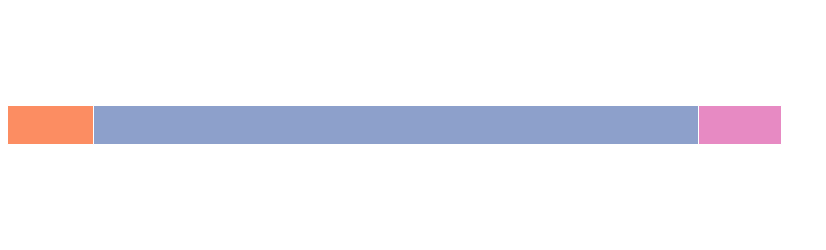

Recipes


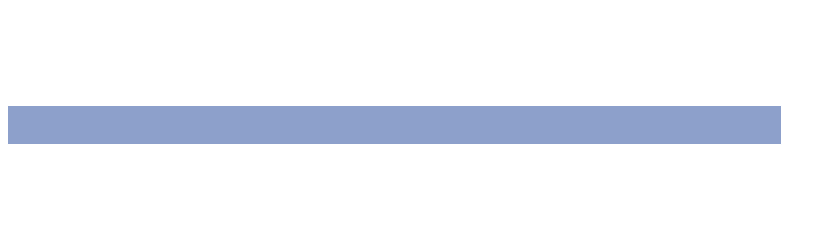

New York Times


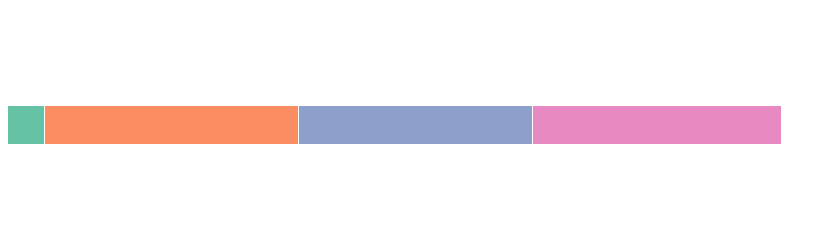

Presidential Speeches


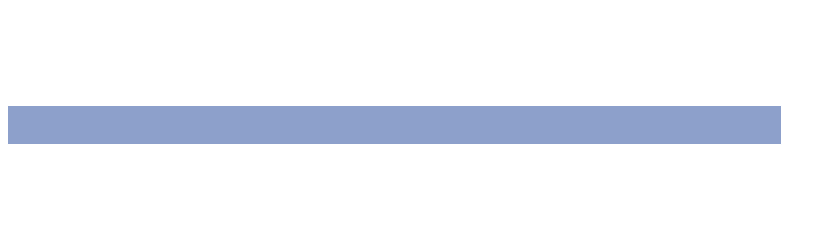

In [361]:
def decide_label(i):
  v = float(values[i])
  if v >= 0:
    return "p={}".format(v)
  else:
    return "rand"

def plot(dataset):
  print(dataset)
  ax = plt.figure(figsize=[12, 4]).subplots(1, 1)

  df3 = df2[df2["dataset"]==dataset]
  ax = df3.plot(kind='barh', stacked=True, width=0.1, ax=ax)

  for i, c in enumerate(ax.containers):
    labels = [decide_label(i) if v.get_width() > 0.0 else '' for v in c]
    
    #ax.bar_label(c, labels=labels, label_type='center', fontsize=26)
  ax.get_legend().remove()
  plt.grid(False)
  plt.axis('off')
  plt.tight_layout()
  ax.set_position((0, 0, 1, 1))
  ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
  ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())

  # plt.savefig("decoding_dist_{}.pdf".format(dataset.lower().replace(" ", "_")), transparent=True)
  plt.show()
  return ax

plot("Short Stories")
plot("Recipes")
plot("New York Times")
plot("Presidential Speeches")

## Models

In [362]:
df = full_df.groupby(['dataset', 'model']).count()
df = df.reset_index()

values = [-1, 0.0, 0.4, 1.0]

df2 = df.filter(items=["dataset", "model", "pk"])
df2 = df2.groupby(['dataset', 'model']).sum().unstack()
df2 = df2.fillna(0)
df2.columns = [str(a[-1]) for a in df2.columns.to_flat_index()]

sums = df2.sum(axis=1)
for col in set(df2.columns) - {"dataset"}:
  df2[col] = df2[col] / sums

models_per_dataset = {
 "New York Times": ["easy", "gpt2-xl", "human"],
 "Presidential Speeches": ["ctrl-Politics", "ctrl-nocode", "human"],
 "Recipes": ["finetuned", "gpt2-xl", "human"],
 "Short Stories": ["gpt2", "gpt2-xl", "human"]   
}


df2 = df2.reset_index()
df2

dataset  ctrl-Politics  ctrl-nocode   davinci      easy  \
0         New York Times       0.000000     0.000000  0.000000  0.042781   
1  Presidential Speeches       0.541882     0.337539  0.000000  0.000000   
2                Recipes       0.000000     0.000000  0.000000  0.000000   
3          Short Stories       0.000000     0.000000  0.014738  0.000000   

   finetuned     gpt2   gpt2-xl     human  
0   0.000000  0.00000  0.852718  0.104501  
1   0.000000  0.00000  0.000000  0.120579  
2   0.668958  0.00000  0.234920  0.096121  
3   0.000000  0.52254  0.299306  0.163416

Short Stories


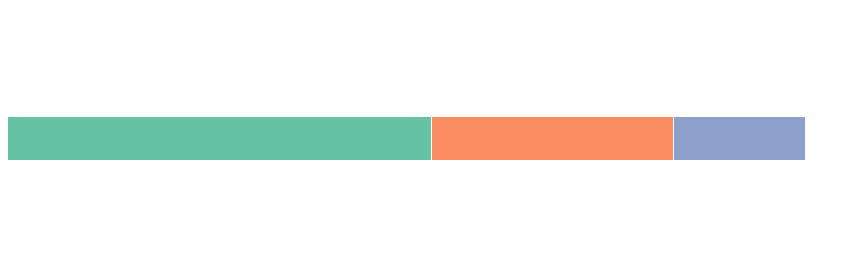

Recipes


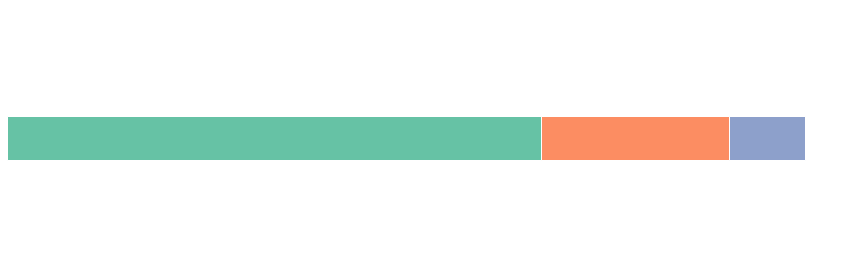

New York Times


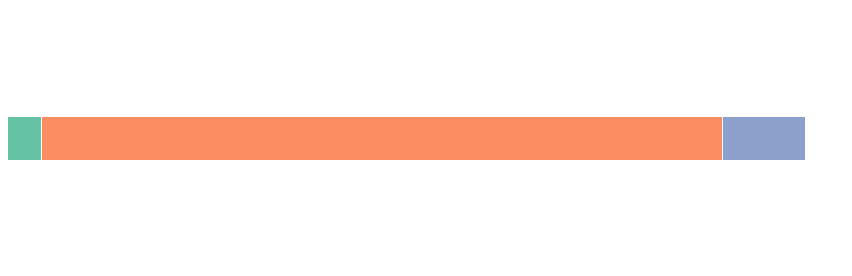

Presidential Speeches


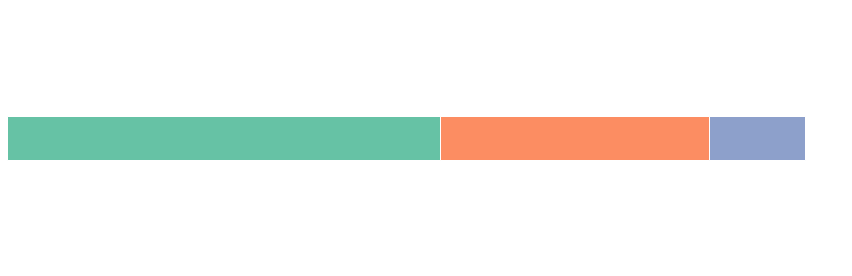

In [363]:
def decide_label(dataset, i):
  name = models_per_dataset[dataset][i]

  name_remap = {
      "gpt2": "gpt2-small",
      "ctrl-nocode": "ctrl-random-code",
      "ctrl-Politics": "ctrl-politics",
      "finetuned": "finetuned gpt2-xl",
      "easy": "rand"
  }

  return name_remap.get(name, name)

def plot(dataset):
  print(dataset)
  ax = plt.figure(figsize=[12, 4]).subplots(1, 1)

  df3 = df2[df2["dataset"]==dataset][models_per_dataset[dataset]]
  ax = df3.plot(kind='barh', stacked=True, width=0.1, ax=ax)

  for i, c in enumerate(ax.containers):
    labels = [decide_label(dataset, i) if v.get_width() > 0.0 else '' for v in c]
    
    #ax.bar_label(c, labels=labels, label_type='center', fontsize=26)
  ax.get_legend().remove()
  plt.grid(False)
  plt.axis('off')
  plt.tight_layout()
  ax.set_position((0, 0, 1, 1))
  ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
  ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())

  plt.savefig("model_dist_{}.pdf".format(dataset.lower().replace(" ", "_")), transparent=True)
  plt.show()
  return ax

plot("Short Stories")
plot("Recipes")
plot("New York Times")
plot("Presidential Speeches")

## Boundary Distributions

In [364]:
def plot_boundary_distribution(dataset, ax, df, dataset_name, boundary_name):

  boundaries = df[df[dataset_name]==dataset][boundary_name].tolist()
  boundaries = collections.Counter(boundaries)

  if boundary_name == "num_sentences":
    data = [boundaries.get(i) for i in range(1,11)]
    labels = range(1,11)
  else:
    data = [boundaries.get(i) for i in range(10)]
    labels = range(10)

  ax.pie(data, labels=labels, autopct='%.0f%%')
  ax.set_title(map_playlist_name(dataset))

In [365]:
df = generation_df
df["gen_pk"] = df["pk"]
df = df.join(prompt_df.set_index("pk"), on="prompt")

playlist_names = [] 
playlist_versions = []
for idx, row in df.iterrows():
  gen_id = row["gen_pk"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
df["playlist_name"] = playlist_names
df["playlist_version"] = playlist_versions
df = df[df["playlist_version"] == "0.2"]

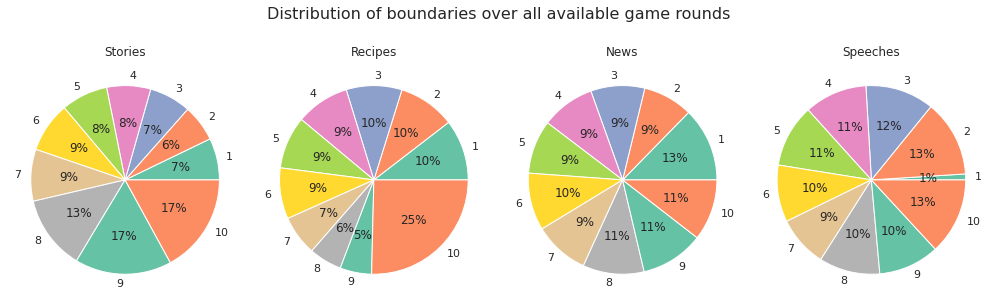

In [366]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 4)
plot_boundary_distribution("Short Stories", axes[0], df, "playlist_name", "num_sentences")
plot_boundary_distribution("Recipes", axes[1], df, "playlist_name", "num_sentences")
plot_boundary_distribution("New York Times", axes[2], df, "playlist_name", "num_sentences")
plot_boundary_distribution("Presidential Speeches", axes[3], df, "playlist_name", "num_sentences")
fig.suptitle('Distribution of boundaries over all available game rounds', fontsize=16)
plt.tight_layout()
plt.savefig("available_game_rounds.pdf")
plt.show()

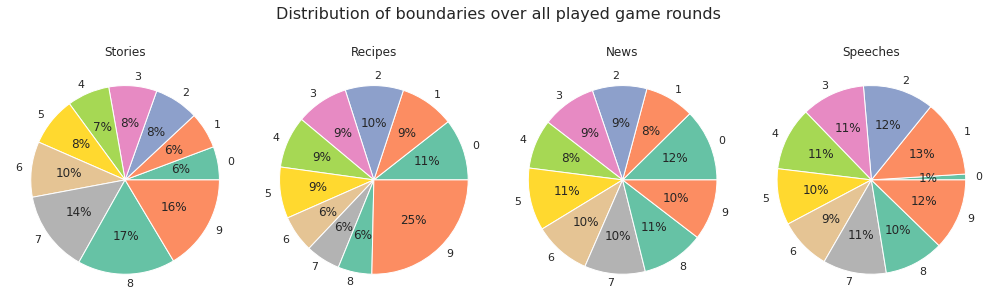

In [367]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 4)
plot_boundary_distribution("Short Stories", axes[0], original_df, "dataset", "true_boundary_index")
plot_boundary_distribution("Recipes", axes[1], original_df, "dataset", "true_boundary_index")
plot_boundary_distribution("New York Times", axes[2], original_df, "dataset", "true_boundary_index")
plot_boundary_distribution("Presidential Speeches", axes[3], original_df, "dataset", "true_boundary_index")
fig.suptitle('Distribution of boundaries over all played game rounds', fontsize=16)
plt.tight_layout()
plt.savefig("played_game_rounds.pdf")
plt.show()

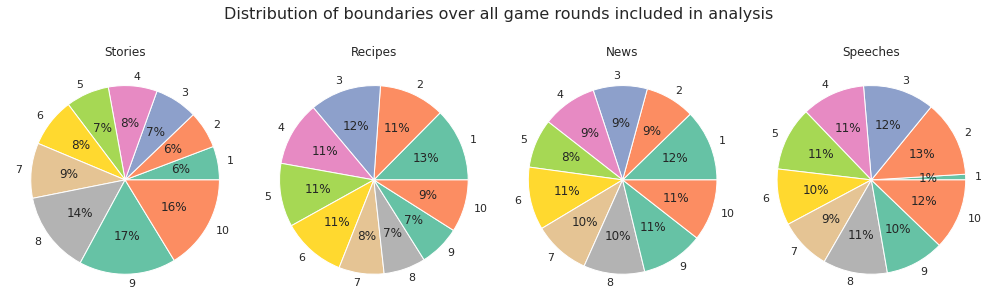

In [368]:
fig = plt.figure(figsize=[14, 5])
axes = fig.subplots(1, 4)
plot_boundary_distribution("Short Stories", axes[0], pre_cleaning_full_df, "playlist_name", "num_sentences")
plot_boundary_distribution("Recipes", axes[1], pre_cleaning_full_df, "playlist_name", "num_sentences")
plot_boundary_distribution("New York Times", axes[2], pre_cleaning_full_df, "playlist_name", "num_sentences")
plot_boundary_distribution("Presidential Speeches", axes[3], pre_cleaning_full_df, "playlist_name", "num_sentences")
fig.suptitle('Distribution of boundaries over all game rounds included in analysis', fontsize=16)
plt.tight_layout()
plt.savefig("analyzed_game_rounds.pdf")
plt.show()

## Histogram of Predicted Boundaries

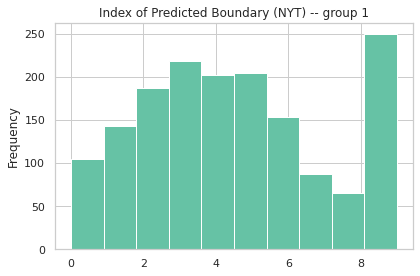

In [369]:
# full_df[full_df["dataset"] == "New York Times"].predicted_boundary_index.plot.hist(
#     title='Achieved Points Distribution (NYT)'
# )

full_df[(full_df["dataset"] == "New York Times") & (full_df['date'] < '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (NYT) -- group 1'
)

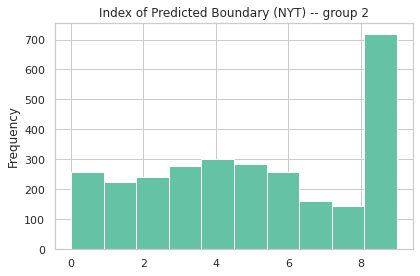

In [370]:
full_df[(full_df["dataset"] == "New York Times") & (full_df['date'] > '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (NYT) -- group 2'
)

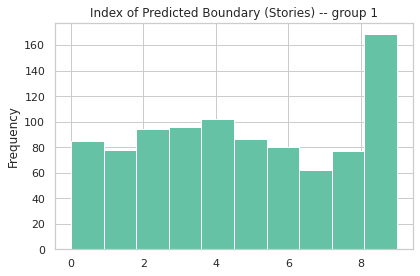

In [371]:
full_df[(full_df["dataset"] == "Short Stories") & (full_df['date'] < '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Stories) -- group 1'
)

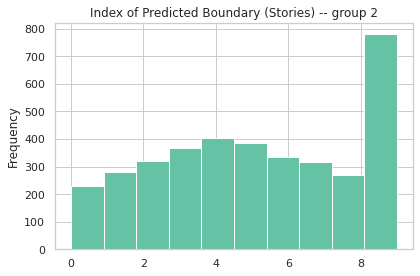

In [372]:
full_df[(full_df["dataset"] == "Short Stories") & (full_df['date'] > '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Stories) -- group 2'
)

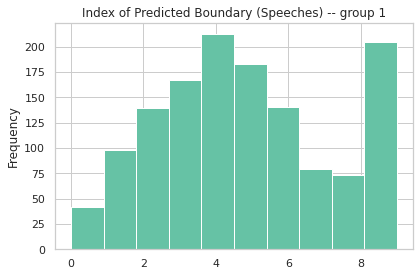

In [373]:
full_df[(full_df["dataset"] == "Presidential Speeches") & (full_df['date'] < '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Speeches) -- group 1'
)

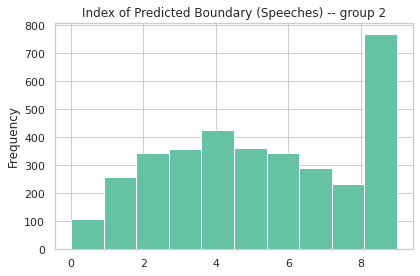

In [374]:
full_df[(full_df["dataset"] == "Presidential Speeches") & (full_df['date'] > '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Speeches) -- group 2'
)

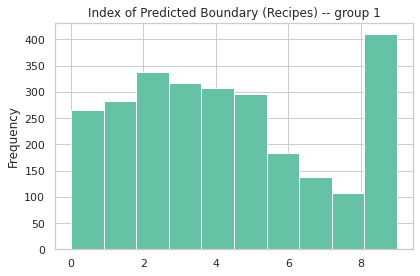

In [375]:
full_df[(full_df["dataset"] == "Recipes") & (full_df['date'] < '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Recipes) -- group 1'
)

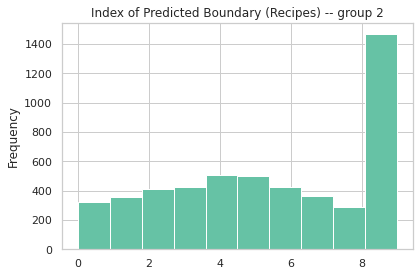

In [376]:
full_df[(full_df["dataset"] == "Recipes") & (full_df['date'] > '2021-10-1') ].predicted_boundary_index.plot.hist(
    title='Index of Predicted Boundary (Recipes) -- group 2'
)

# Final graphs for paper

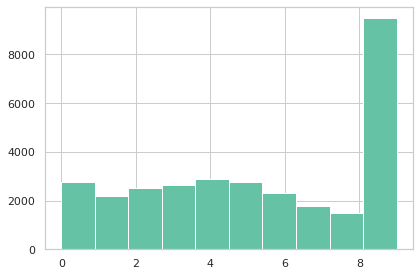

In [377]:
original_df[~original_df['annotator'].isin([4334])].predicted_boundary_index.plot.hist()
plt.ylabel('')
plt.savefig('histogram.pdf')

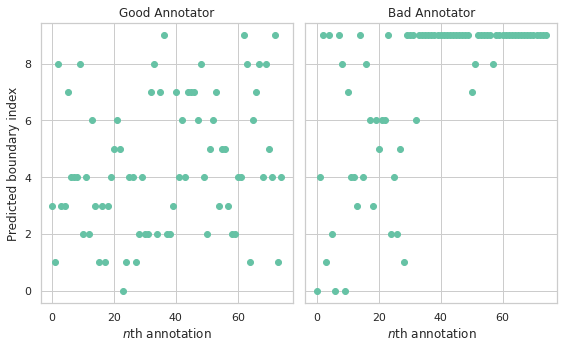

In [378]:
fig = plt.figure(figsize=[8, 5])
axes = fig.subplots(1, 2, sharey=True)
ys1 = original_df[original_df["annotator"] == 5409].sort_values("date")["predicted_boundary_index"].tolist()
ys2 = original_df[original_df["annotator"] == 5411].sort_values("date")["predicted_boundary_index"].tolist()
axes[0].scatter(x=range(75), y=ys1[:75])
axes[1].scatter(x=range(75), y=ys2[:75])
axes[0].set_title("Good Annotator")
axes[0].set(xlabel="$n$th annotation", ylabel="Predicted boundary index")
axes[1].set_title("Bad Annotator")
axes[1].set(xlabel="$n$th annotation")

plt.savefig("goodvsbad.pdf")
plt.show()

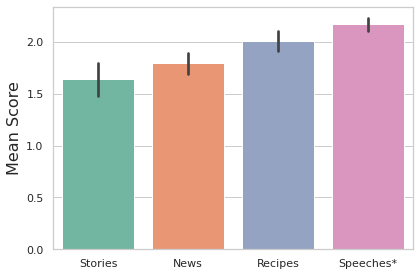

In [379]:
filtered_df = full_df[((full_df["model"]=="gpt2-xl") | (full_df["model"]=="ctrl-Politics") | (full_df["model"]=="ctrl-nocode")) & 
                      (full_df["dec_strat_value"]==0.4)]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["model"] = filtered_df["model"].apply(lambda x: "ctrl" if "ctrl" in x else x)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dataset"] = filtered_df["dataset"].apply(lambda x: "Speeches*" if "Speeches" in x else x)

# p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes"])
p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["Stories", "News", "Recipes", "Speeches*"])

p.set_title("")
p.set_xlabel("")

matplotlib.rc('xtick', labelsize=12) 
p.set_ylabel("Mean Score", fontsize = 16)
plt.savefig("genre.pdf")

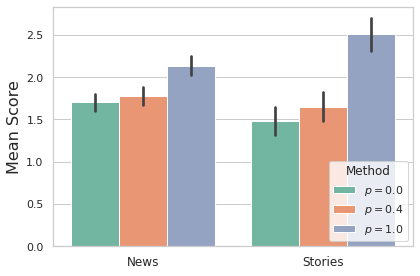

In [380]:
filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times") &
                      (full_df["dec_strat_value"] != -1)]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df, hue_order=["$p=0.0$","$p=0.4$","$p=1.0$"])
# p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
matplotlib.rc('xtick', labelsize=12) 
plt.tight_layout()
plt.savefig("topp.pdf")

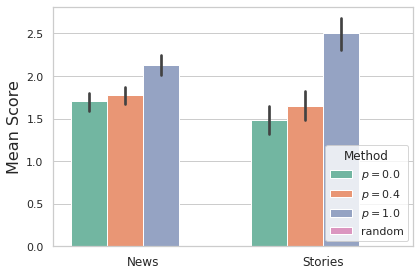

In [381]:
filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)

order = ["$p=0.0$","$p=0.4$","$p=1.0$", "random"]
p = plt.figure(figsize=[6, 4]).subplots(1, 1)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df, hue_order=order, ax=p, )
p.set_xlabel("", fontsize=16)
p.set_ylabel("Mean Score", fontsize = 16)
# p.set_xticks(order, fontsize=16)
p.legend(loc="lower right").set_title("Method")
matplotlib.rc('xtick', labelsize=12) 

plt.tight_layout()
plt.savefig("topp_with_baseline.pdf")

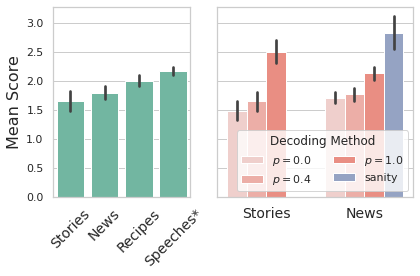

In [382]:
figure = plt.figure(figsize=[6, 4], tight_layout=True)
axes = figure.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [0.7, 1]})
matplotlib.rc('xtick', labelsize=12) 

filtered_df = full_df[((full_df["model"]=="gpt2-xl") | (full_df["model"]=="ctrl-Politics") | (full_df["model"]=="ctrl-nocode")) & 
                      (full_df["dec_strat_value"]==0.4)]
filtered_df = copy.deepcopy(filtered_df)
filtered_df = copy.deepcopy(filtered_df)
filtered_df["model"] = filtered_df["model"].apply(lambda x: "ctrl" if "ctrl" in x else x)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
def rename(x):
  if x=="Speeches":
    x = "Speeches*"
  elif x=="Recipes":
    x = "Recipes"
  return x
filtered_df["dataset"] = filtered_df["dataset"].apply(rename)

palette=sns.color_palette("Set2")[:1]
order = ["Stories", "News", "Recipes", "Speeches*"]
# p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes"])
ax = sns.barplot(x="dataset", y="points", data=filtered_df, order=order, ax=axes[0], palette=palette)
ax.set_title("")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45)
ax.set_ylabel("Mean Score", fontsize = 16)
# plt.savefig("genre.pdf")

palette = sns.light_palette("Salmon", n_colors=4)[1:4] + [sns.color_palette("Set2")[2]]

filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)
filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)

order = ["$p=0.0$","$p=0.4$","$p=1.0$", "sanity"]
ax = sns.barplot(x="dataset", y="points", hue="dec_strat_value", order=["Stories", "News"], data=filtered_df, hue_order=order, ax=axes[1], palette=palette)
ax.set_xlabel("", fontsize = 16)
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
# ax.legend(loc="upper left", bbox_to_anchor=(-.3, 1)).set_title("Decoding Method")
ax.legend(loc="lower right", ncol=2).set_title("Decoding Method")
plt.savefig("domain_topp.pdf")

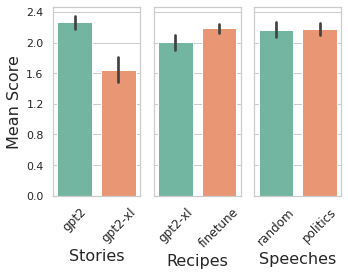

In [383]:
fig = plt.figure(figsize=[5, 4])
axes = fig.subplots(1, 3, sharey=True)
# plt.rcParams["figure.autolayout"] = True
matplotlib.rc('xtick', labelsize=14) 



filtered_df = full_df[(full_df["dataset"]=="Short Stories") & 
                                     (full_df["dec_strat_value"]==0.4) & 
                                     (full_df["model"]!="davinci") & (full_df["model"] != "human")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'gpt2' if x == 'gpt2' else x)
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[0])
p.set_title("")
p.set_xlabel("Stories", fontsize=16)
p.set_ylabel("Mean Score", fontsize=16)
p.set_yticks(np.arange(0, 2.6, 0.4))
p.set_xticklabels(p.get_xticklabels(), rotation=45)
                  
filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'finetune' if x == 'finetuned' else 'gpt2-xl')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[1], order=["gpt2-xl", "finetune"])
p.set_title("")
p.set_xlabel("Recipes", fontsize=16)
p.set_xticklabels(p.get_xticklabels(), rotation=45)
p.set_ylabel("")

filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]
filtered_df = copy.deepcopy(filtered_df)
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'random' if x == 'ctrl-nocode' else 'politics')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[2])
p.set_title("")
p.set_xlabel("Speeches", fontsize=16)
p.set_xticklabels(p.get_xticklabels(), rotation=45)

p.set_ylabel("")

plt.tight_layout()
plt.savefig("model_size_and_finetuning.pdf")
plt.show()

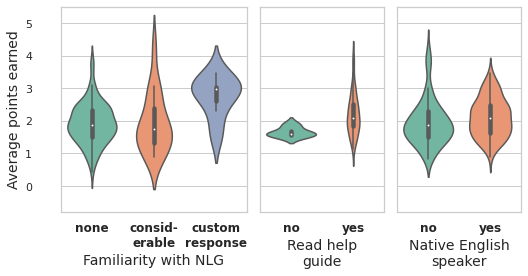

In [384]:
SHOW_FAMILIARTIES = False

if SHOW_FAMILIARTIES:
  fig = plt.figure(figsize=[15, 4])
  fig.tight_layout(pad=0)
  width_ratios = [0.1, 3, 2, 2, 2, 2, 2]
  axes = fig.subplots(1, len(width_ratios), sharey=True, gridspec_kw={'width_ratios': width_ratios})
else:
  fig = plt.figure(figsize=[7.5, 4])
  fig.tight_layout(pad=0)
  width_ratios = [0.1, 3, 2, 2]
  axes = fig.subplots(1, len(width_ratios), sharey=True, gridspec_kw={'width_ratios': width_ratios})

ax = axes[0]
ax.set_ylim([-0.8, 5.5])
ax.set_ylabel("Average points earned", fontsize=14)
ax.grid(visible=False)
ax.xaxis.set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.subplots_adjust(wspace=0)

# Familiarity
order = collections.OrderedDict([(1, "none"), (4, "consid-\nerable"), (-1, "custom\nresponse")])
df=full_df_freq10.groupby(["username", "gen_familiarity"]).points.mean().reset_index()
df = df[(df["gen_familiarity"] == -1) | (df["gen_familiarity"] == 1) | (df["gen_familiarity"] == 4)]
df["gen_familiarity"] = df["gen_familiarity"].apply(lambda x: order[x])
ax = sns.violinplot(x="gen_familiarity", y="points", data=df, order=order.values(), ax=axes[1])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold', rotation=0)
ax.set_ylabel("")
ax.set_xlabel("Familiarity with NLG", fontsize=14)

# Read guide
order = collections.OrderedDict([("No", "no"), ("Yes", "yes")])
df = full_df_freq20[full_df_freq20["read_guide"] != ""]
df=df.groupby(["username", "read_guide"]).points.mean().reset_index()
df["read_guide"] = df["read_guide"].apply(lambda x: order[x])
ax = sns.violinplot(x="read_guide", y="points", data=df, order=order.values(), ax=axes[2])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Read help\nguide", fontsize=14)

# Native English speaker
df = full_df_freq20[full_df_freq20["english"] != ""]
df=df.groupby(["username", "english"]).points.mean().reset_index()
ax = sns.violinplot(x="english", y="points", data=df, ax=axes[3])
ax.set_xticklabels(order.values(), fontsize=12, fontweight='bold')
ax.set_ylabel("")
ax.set_xlabel("Native English\nspeaker", fontsize=14)

if SHOW_FAMILIARTIES:
  # Recipe familiarity
  order = [1, 5]
  df = full_df_freq20[(full_df_freq20["recipe_familiarity"] == 1) | (full_df_freq20["recipe_familiarity"] == 5)]
  df = df[df['dataset']=="Recipes"].groupby(["username", "recipe_familiarity"]).points.mean().reset_index()
  ax = sns.violinplot(x="recipe_familiarity", y="points", data=df, ax=axes[4])
  ax.set_xticklabels(order, fontsize=12, fontweight='bold')
  ax.set_ylabel("")
  ax.set_xlabel("Familiarity with\nrecipes", fontsize=14)

  # News familiarity
  order = [1, 5]
  df = full_df_freq20[(full_df_freq20["news_familiarity"] == 1) | (full_df_freq20["news_familiarity"] == 5)]
  df = df[df['dataset']=="Recipes"].groupby(["username", "news_familiarity"]).points.mean().reset_index()
  ax = sns.violinplot(x="news_familiarity", y="points", data=df, ax=axes[5])
  ax.set_xticklabels(order, fontsize=12, fontweight='bold')
  ax.set_ylabel("")
  ax.set_xlabel("Familiarity with\nnews", fontsize=14)

  # Fiction familiarity
  order = [1, 5]
  df = full_df_freq20[(full_df_freq20["stories_familiarity"] == 1) | (full_df_freq20["stories_familiarity"] == 5)]
  df = df[df['dataset']=="Recipes"].groupby(["username", "stories_familiarity"]).points.mean().reset_index()
  ax = sns.violinplot(x="stories_familiarity", y="points", data=df, ax=axes[6])
  ax.set_xticklabels(order, fontsize=12, fontweight='bold')
  ax.set_ylabel("")
  ax.set_xlabel("Familiarity with\nfiction", fontsize=14)
plt.tight_layout()
plt.savefig("survey_results_no_fam.pdf")
plt.show()

In [385]:
print(full_df.columns)

Index(['date', 'annotator', 'generation', 'playlist',
       'predicted_boundary_index', 'points', 'reason', 'pk', 'model', 'prompt',
       'gen_body', 'prompt_body', 'true_boundary_index', 'prompt_index',
       'dec_strat_value', 'username', 'date_joined', 'dataset', 'Timestamp',
       'Email Address', 'major', 'english', 'recipe_familiarity',
       'news_familiarity', 'stories_familiarity', 'gen_familiarity',
       'read_guide'],
      dtype='object')


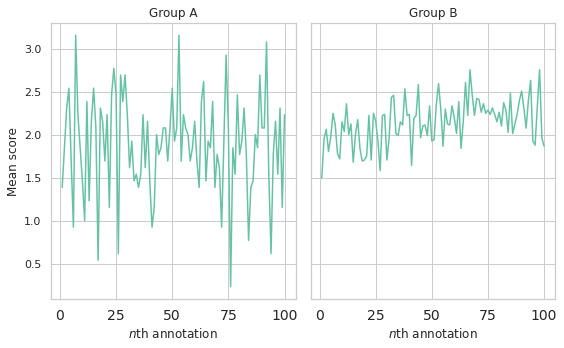

In [386]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

fig = plt.figure(figsize=[8, 5])
axes = fig.subplots(1, 2, sharey=True)
s1, n1 = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), 100)
s2, n2 = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), 100)

axes[0].plot(range(1, 100+1), np.mean(np.array(s1), axis=0))
axes[1].plot(range(1, 100+1), np.mean(np.array(s2), axis=0))
axes[0].set_title("Group A")
axes[0].set(xlabel="$n$th annotation", ylabel="Mean score")
axes[1].set_title("Group B")
axes[1].set(xlabel="$n$th annotation")

plt.savefig("overtime.pdf")
plt.show()

# Analysis of Annotations

### Correlations with other possible metrics

In [387]:
df = copy.deepcopy(full_df)

def foo(row):
  import pdb; pdb.set_trace()
  return row

df["correctly_after_boundary"] = df.predicted_boundary_index >= df.true_boundary_index
df["perfect"] = df.predicted_boundary_index == df.true_boundary_index
df["distance"] = df.apply(lambda row: np.max(row["predicted_boundary_index"] - row["true_boundary_index"], 0), axis=1)

df = df.groupby(["username"]).mean().reset_index()

for metric in ["correctly_after_boundary", "perfect", "distance"]:
  spearman = stats.spearmanr(df[metric], df["points"])
  pearson = stats.pearsonr(df[metric], df["points"])

  print("spearmanr for %s: %.2f, %f" % (metric, spearman[0], spearman[1]))
  print("pearsonr for %s: %.2f, %f\n" % (metric, pearson[0], pearson[1]))


spearmanr for correctly_after_boundary: 0.73, 0.000000
pearsonr for correctly_after_boundary: 0.75, 0.000000

spearmanr for perfect: 0.88, 0.000000
pearsonr for perfect: 0.89, 0.000000

spearmanr for distance: 0.30, 0.000002
pearsonr for distance: 0.32, 0.000000



### Correlations with sentence statistics

* Sentence length / relative sentence length
* Frequency of new noun phrases
* Fraction of various parts of speech
* Number of new named entities
* Likelihood
* Number of stop words

In [388]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-08-15 20:15:54.570426: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 8.1 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [389]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [390]:
cache = {}

In [391]:
def aggregate(data):
  if data.name == "predicted_boundary_index":
    return collections.Counter(list(data))
  else:
    compressed = list(set(data))
    if len(compressed) == 1:
      return compressed[0]

def is_descriptive(x):
  return x.pos_ in ["ADJ", "ADV"]

def is_noun(x):
  return x.pos_ in ["PRON", "PROPN", "NOUN"]

In [392]:
all_stats = []
for dataset in set(full_df["dataset"].tolist()) - {"Recipes"}:
  print(dataset)
  df = full_df[full_df["dataset"]==dataset].groupby("generation").agg(aggregate)
  df = df.reset_index()
  
  bad = 0
  for idx, row in df.filter(items=["true_boundary_index", "predicted_boundary_index", "prompt_body", "gen_body"]).iterrows():
    # if idx > 100:
    #   break

    prompt = row["prompt_body"]
    gen = row["gen_body"]

    assert isinstance(prompt, str)
    assert isinstance(gen, str)

    prompt = prompt.split("_SEP_")
    gen = gen.split("_SEP_") if gen else []

    all_sentences = prompt + gen[:(10 - len(prompt))]
    # if len(all_sentences) != 10:

    # if (any(x >= 10 for x in predicted_indexes.keys())):
    # if predicted_index > len(all_sentences):
    if len(all_sentences) != 10:
      # import pdb; pdb.set_trace()
      bad += 1
      continue

    first_gen_idx = len(prompt)

    predicted_indexes = {k+1:count for k, count in row["predicted_boundary_index"].items()}

    for s in all_sentences:
      if s not in cache:
        cache[s] = nlp(s)

    all_sentences = [cache[s] for s in all_sentences]

    ents_seen_so_far = set([e.text.lower() for e in all_sentences[0].ents])
    words_seen_so_far = set(w.text.lower() for w in all_sentences[0])

    num_stop_words = []
    for sdx in range(1, len(all_sentences)):
      sentence = all_sentences[sdx]

      ents = set(sentence.ents)
      num_non_new_ents = sum(e.text.lower() in ents_seen_so_far for e in ents)
      num_new_ents = sum(e.text.lower() not in ents_seen_so_far for e in ents)

      num_non_new_words = sum(w.text.lower() in words_seen_so_far for w in sentence)
      num_new_words = sum(w.text.lower() not in words_seen_so_far for w in sentence)

      ents_seen_so_far.update(e.text.lower() for e in ents)
      words_seen_so_far.update(w.text.lower() for w in sentence)

      num_stop_words = sum(w.text in spacy.lang.en.stop_words.STOP_WORDS for w in sentence)

      predictions_on_sentence = predicted_indexes.get(sdx, 0) / sum(predicted_indexes.values())

      num_nouns = sum(is_noun(x) for x in sentence)
      num_descriptive = sum(is_descriptive(x) for x in sentence)

      stats = {
          "len": len(sentence),
          "ratio_of_len_to_previous": len(sentence) / len(all_sentences[sdx-1]),
          "ratio_of_len_to_mean_previous": len(sentence) / np.mean([len(s) for s in all_sentences[:(sdx)]]),
          "num_new_ents": num_new_ents,
          "num_ents_total": len(ents),
          "fraction_new_ents": num_new_ents / len(sentence),
          "fraction_ents": len(ents) / len(sentence),
          "num_new_words": num_new_words,
          "fraction_new_words": num_new_words / len(sentence),
          "num_stop_words": len(sentence) - num_stop_words,
          "num_non_stop_words": num_stop_words,
          "fraction_stop_words": num_stop_words / len(sentence),
          "fraction_non_stop_words": 1 - (num_stop_words / len(sentence)),
          "fraction_preds_on_sentence": predictions_on_sentence,
          "fraction_nouns": num_nouns / len(sentence),
          "fraction_descriptive": num_descriptive / len(sentence),
          "was_picked_by_annotator": predicted_indexes.get(sdx, 0) > 0,
          "is_true_boundary": sdx == first_gen_idx,
          "is_generated": sdx >= first_gen_idx,
          "dataset": dataset,
      }

    all_stats.append(stats)
  print("Number bad:", bad)

New York Times


/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


Number bad: 41
Short Stories


/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


Number bad: 14
Presidential Speeches


/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


Number bad: 0


In [393]:
# import pickle as pkl
# with open("spacy_dump.pkl", "wb") as f:
#   pkl.dump(cache, f)

In [394]:
def name_mapping(x):
  mapping = {
    "fraction_new_words": "new word",
    "fraction_non_stop_words": "not stopword",
    "fraction_nouns": "noun/pronoun",
    "fraction_descriptive": "adj/adv",
    "ratio_of_len_to_previous": "len / len prev",
    "ratio_of_len_to_mean_previous": "len / len\nall previous",
    "fraction_ents": "num ents / len",
    "fraction_new_ents": "num new ents / len",
    "num_ents_total": "named entity",
    "num_new_ents": "novel named entity",
    True: "yes",
    False: "no",
  }
  return mapping.get(x, x)
# for metric in ["len", "ratio_of_len_to_previous", "ratio_of_len_to_mean_previous", "num_new_ents", "num_ents_total", "num_stop_words", "fraction_stop_words"]:
# for metric in ["ratio_of_len_to_previous", "ratio_of_len_to_mean_previous", "num_new_ents", "num_ents_total", "fraction_stop_words"]:
# for metric in ["fraction_nouns", "fraction_descriptive"]:
# for metric in ["fraction_new_ents", "fraction_ents"]:

def gen_df_with_metrics(metrics, dataset):
  all_stats_rejigged = []
  for row in all_stats:
    if row["dataset"] == dataset:
      for metric in metrics:
        new_row = {
          "fraction_preds_on_sentence": row["fraction_preds_on_sentence"],
          "was_picked_by_annotator": name_mapping(row["was_picked_by_annotator"]),
          "is_true_boundary": name_mapping(row["is_true_boundary"]),
          "is_generated": name_mapping(row["is_generated"]),
          "metric": name_mapping(metric),
          "value": row[metric],
        }
        all_stats_rejigged.append(new_row)
  df = pd.DataFrame(all_stats_rejigged)
  return df

def gen_compressed_df_with_metrics(metrics, dataset):
  all_stats_rejigged = []
  for row in all_stats:
    if row["dataset"] == dataset:
      for metric in metrics:
        datapoint = {
          "metric": name_mapping(metric),
          "value": row[metric],
        }
        dp1 = copy.deepcopy(datapoint)
        if row["was_picked_by_annotator"]:
          dp1["type"] = "Selected by ≥1 players"
        else:
          dp1["type"] = "Never selected by player"
        
        dp2 = copy.deepcopy(datapoint)
        if row["is_generated"]:
          dp2["type"] = "Machine-generated"
        else:
          dp2["type"] = "Human-written"        

        all_stats_rejigged.extend([dp1, dp2])
  hue_order = ["Human-written", "Machine-generated", "Never selected by player", "Selected by ≥1 players"]
  df = pd.DataFrame(all_stats_rejigged)
  return df, hue_order

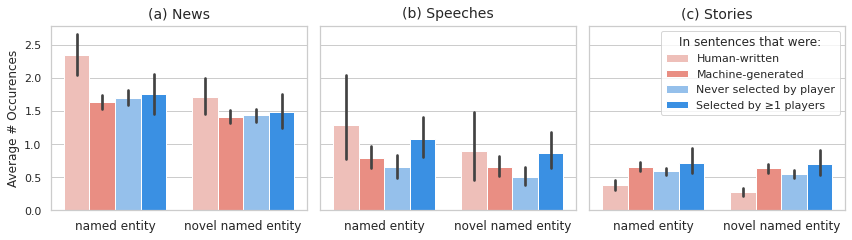

In [395]:
# df = gen_df_with_metrics(["len", "num_new_words", "num_non_stop_words"])

def make_word_based_plot(ax, letter, dataset, legend=True):
  palette = sns.light_palette("Salmon", n_colors=3)[1:3] + sns.light_palette("DodgerBlue", n_colors=3)[1:3]


  # metrics = ["ratio_of_len_to_previous", "ratio_of_len_to_mean_previous", "
  metrics = ["num_ents_total", "num_new_ents"]
  df, hue_order = gen_compressed_df_with_metrics(metrics, dataset)

  ax = sns.barplot(x="metric", y="value", hue="type", hue_order=hue_order, palette=palette, data=df, ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)
  ax.set_ylabel("")
  # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "%2.0f%%" % (y * 100)))
  if legend:
    ax.legend(title="In sentences that were:", loc="upper right")
  else:
    ax.get_legend().remove()
  ax.set_title("({}) {}".format(letter, map_playlist_name(dataset)), y=1.01, fontsize=14)
  ax.set_xlabel("")

figure = plt.figure(figsize=[12, 3.5], tight_layout=True)
axes = figure.subplots(1, 3, sharey=True)
make_word_based_plot(axes[0], "a", "New York Times", legend=False)
make_word_based_plot(axes[1], "b", "Presidential Speeches", legend=False)
make_word_based_plot(axes[2], "c", "Short Stories", legend=True)
axes[0].set_ylabel("Average # Occurences")
plt.tight_layout()
plt.savefig("ner_stats.pdf")
plt.show()

### Mean points per playlist

In [396]:
def analyze_per_playlist():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  for playlist in playlist_names:
    for model in model_names:
      if 'ctrl' in model:
        model = 'ctrl'
        df = full_df[(full_df["dataset"]==playlist) & ((full_df["model"]=='ctrl-Politics') | (full_df["model"]=='ctrl-nocode'))]
      else:
        df = full_df[(full_df["dataset"]==playlist) & 
                            (full_df["model"]==model)]
      
      if len(df) > 0:
        info = {"playlist": playlist,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "95% conf intvl": mean_confidence_interval_me(df["points"]),
                # "std dev": np.std(df["points"]),
                # "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_playlist()

playlist      model  mean score  median score  \
0                 Recipes  finetuned    2.183828           2.0   
1                 Recipes    gpt2-xl    2.004417           1.0   
2                 Recipes      human    2.290148           0.0   
3          New York Times    gpt2-xl    1.886595           1.0   
4          New York Times       easy    2.755208           3.0   
5          New York Times      human    1.784648           0.0   
6           Short Stories    davinci    1.764706           1.0   
7           Short Stories    gpt2-xl    1.866763           1.0   
8           Short Stories      human    1.823607           0.0   
9           Short Stories       gpt2    2.262547           2.0   
10  Presidential Speeches       ctrl    2.170978           2.0   
11  Presidential Speeches       ctrl    2.170978           2.0   
12  Presidential Speeches      human    1.989708           0.0   

         95% conf intvl  num_annotations  
0   (-0.05831, 0.05831)             5157  
1   (-0.09811, 0.09811)             1811  
2   (-0.17729, 0.17729)              741  
3     (-0.0628, 0.0628)             3827  
4   (-0.30696, 0.30696)              192  
5   (-0.21557, 0.21557)              469  
6   (-0.43868, 0.43868)               68  
7   (-0.10241, 0.10241)             1381  
8   (-0.17147, 0.17147)              754  
9   (-0.08545, 0.08545)             2411  
10  (-0.06174, 0.06174)             4252  
11  (-0.06174, 0.06174)             4252  
12  (-0.19883, 0.19883)              583

In [397]:
def analyze_per_decoding_strat():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  model_names.remove('human')
  for playlist in playlist_names:
    for model in model_names:
      for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        df = full_df[(full_df["dec_strat_value"]==top_p_value) &
                  (full_df["dataset"]==playlist) &
                  (full_df["model"]==model)]

        if len(df) > 0:
          info = {"p-value": top_p_value,
                  "playlist": playlist,
                  "model": model,
                  "mean_score": np.mean(df["points"]),
                  "95% conf intvl": mean_confidence_interval_me(df["points"]),
                  "std_dev": np.std(df["points"]),
                  # "median_score": np.median(df["points"]),
                  # "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                  "num_annotations": len(df),
          }
          info_to_return.append(info)
  return pd.DataFrame(info_to_return)

per_p_df = analyze_per_decoding_strat()
per_p_df

p-value               playlist          model  mean_score  \
0       0.4                Recipes      finetuned    2.183828   
1       0.4                Recipes        gpt2-xl    2.004417   
2       0.0         New York Times        gpt2-xl    1.680147   
3       0.4         New York Times        gpt2-xl    1.792815   
4       1.0         New York Times        gpt2-xl    2.196063   
5       0.4          Short Stories        davinci    1.764706   
6       0.0          Short Stories        gpt2-xl    1.484009   
7       0.4          Short Stories        gpt2-xl    1.645299   
8       1.0          Short Stories        gpt2-xl    2.504505   
9       0.4          Short Stories           gpt2    2.262547   
10      0.4  Presidential Speeches    ctrl-nocode    2.166667   
11      0.4  Presidential Speeches  ctrl-Politics    2.173664   

         95% conf intvl   std_dev  num_annotations  
0   (-0.05831, 0.05831)  2.136406             5157  
1   (-0.09811, 0.09811)  2.129694             1811  
2   (-0.10223, 0.10223)  1.922748             1360  
3   (-0.10923, 0.10923)  1.927382             1197  
4   (-0.11312, 0.11312)  2.055946             1270  
5   (-0.43868, 0.43868)  1.832048               68  
6   (-0.16359, 0.16359)  1.805659              469  
7   (-0.16797, 0.16797)  1.851956              468  
8   (-0.18734, 0.18734)  2.011785              444  
9   (-0.08545, 0.08545)  2.140329             2411  
10    (-0.0993, 0.0993)  2.046139             1632  
11  (-0.07884, 0.07884)  2.058680             2620

In [398]:
def analyze_per_generation_length():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  model_names = set(full_df["model"].tolist())
  model_names.remove('human')
  for gen_len in range(10):
    df = full_df[(full_df["true_boundary_index"]==gen_len)]

    if len(df) > 0:
      info = {"true_boundary_index": gen_len,
              "mean_score": np.mean(df["points"]),
              "std_dev": np.std(df["points"]),
              "95% conf intvl": mean_confidence_interval_me(df["points"]),
              "median_score": np.median(df["points"]),
              "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
              "num_annotations": len(df),
      }
      info_to_return.append(info)
  return pd.DataFrame(info_to_return)

per_p_df = analyze_per_generation_length()
per_p_df

true_boundary_index  mean_score   std_dev       95% conf intvl  \
0                    0    1.948857  2.032006  (-0.09292, 0.09292)   
1                    1    2.165751  2.031348  (-0.08521, 0.08521)   
2                    2    2.288947  2.038163  (-0.08335, 0.08335)   
3                    3    2.288120  2.048415  (-0.08567, 0.08567)   
4                    4    2.212208  2.164279  (-0.09265, 0.09265)   
5                    5    2.169591  2.045486  (-0.08505, 0.08505)   
6                    6    1.907966  2.006886  (-0.09128, 0.09128)   
7                    7    1.929513  2.068196  (-0.08646, 0.08646)   
8                    8    1.957187  2.213170  (-0.09068, 0.09068)   
9                    9    1.934633  2.435233  (-0.09619, 0.09619)   

   median_score  fraction_nonzero  num_annotations  
0           1.0          0.567465             1838  
1           2.0          0.618132             2184  
2           2.0          0.641862             2298  
3           2.0          0.621302             2197  
4           2.0          0.565093             2097  
5           1.0          0.663068             2223  
6           2.0          0.541981             1858  
7           0.0          0.490223             2199  
8           0.0          0.444299             2289  
9           0.0          0.386927             2463

### Comparison of XL models across p-values for NYT and Reddit

**Conclusion**: Sampling from full distribution (p=1.0) has worse quality. Argmax sampling (with repetition penalty) seems to be consistently better for text quality -- this is consistent with Daphne's research.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


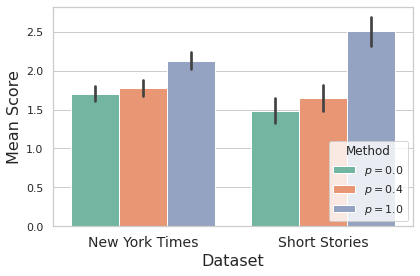

In [399]:
filtered_df = full_df[
                      (full_df["model"]=="gpt2-xl") & 
                      (full_df["dataset"]=="Short Stories") | (full_df["dataset"]=="New York Times") &
                      (full_df["dec_strat_value"] != -1)]

filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
p = sns.barplot(x="dataset", y="points", hue="dec_strat_value", data=filtered_df, hue_order=["$p=0.0$","$p=0.4$","$p=1.0$"])
# p.set_title("Comparison of Generation Performance of GPT2-XL across values of top-p")
p.set_xlabel("Dataset", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)
p.legend(loc="lower right").set_title("Method")
plt.tight_layout()
plt.savefig("topp.pdf")

### Comparison of GPT2-XL p=0.4 across reddit, nyt, and recipes

**Conclusion:** We see that Recipes are the most difficult, then NYT and short stories. This shows that generation systems struggle with structured text and are better at more open-ended generations (?). Also shows that domain knowledge is important. (although NYT being better than reddit is interesting).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


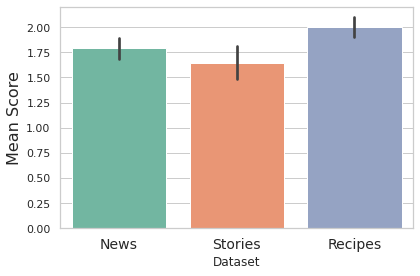

In [400]:
filtered_df = full_df[((full_df["model"]=="gpt2-xl")) & 
                                     (full_df["dec_strat_value"]==0.4)]

filtered_df["dec_strat_value"] = filtered_df["dec_strat_value"].apply(map_p_value)
filtered_df["dataset"] = filtered_df["dataset"].apply(map_playlist_name)

p = sns.barplot(x="dataset", y="points", data=filtered_df, order=["News", "Stories", "Recipes"])
p.set_title("")
p.set_xlabel("Dataset")
p.set_ylabel("Mean Score", fontsize = 16)
plt.savefig("genre.pdf")

### Comparison of Model Size across same dataset and p-value

**Conclusion**: Bigger Models are better (good sanity check, nice to know this is confirmed) -- don't use GPT3 here because we only have 89 annotations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


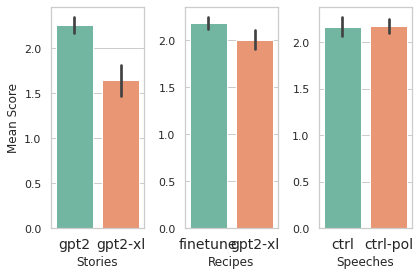

In [401]:
filtered_df = full_df[(full_df["dataset"]=="Short Stories") & 
                                     (full_df["dec_strat_value"]==0.4) & 
                                     (full_df["model"]!="davinci") & (full_df["model"] != "human")]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)
p = sns.barplot(x="model", y="points", data=filtered_df, ax=axes[0])
p.set_title("")
p.set_xlabel("Stories")
p.set_ylabel("Mean Score")

filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'finetune' if x == 'finetuned' else 'gpt2-xl')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[1])
p.set_title("")
p.set_xlabel("Recipes")
p.set_ylabel("")

filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]
filtered_df['to_plot'] = filtered_df['model'].apply(lambda x: 'ctrl' if x == 'ctrl-nocode' else 'ctrl-pol')
p = sns.barplot(x="to_plot", y="points", data=filtered_df, ax=axes[2])
p.set_title("")
p.set_xlabel("Speeches")
p.set_ylabel("")

plt.savefig("model_size_and_finetuning.pdf")
plt.show()

### Comparison of fine-tuning performance

Text(0, 0.5, 'Mean Score')

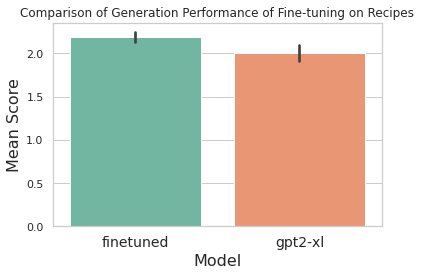

In [402]:
filtered_df = full_df[(full_df["dataset"]=="Recipes") & (full_df["model"]!="human")]

p = sns.barplot(x="model", y="points", data=filtered_df)
p.set_title("Comparison of Generation Performance of Fine-tuning on Recipes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

Text(0, 0.5, 'Mean Score')

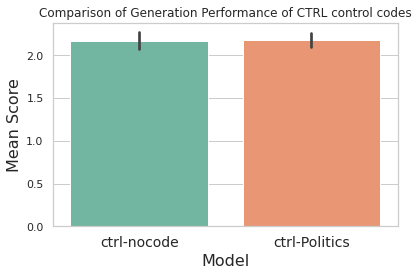

In [403]:
filtered_df = full_df[(full_df["dataset"]=="Presidential Speeches") & (full_df["model"]!="human")]

p = sns.barplot(x="model", y="points", data=filtered_df)
p.set_title("Comparison of Generation Performance of CTRL control codes")
p.set_xlabel("Model", fontsize = 16)
p.set_ylabel("Mean Score", fontsize = 16)

###Mean Points for users that have no familiarity with generated text vs. users that do

(-0.6, 5.5)

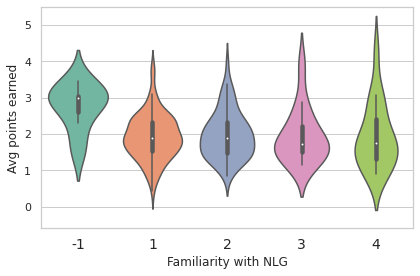

In [404]:
df_familiarity=full_df_freq10.groupby(["username", "gen_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"gen_familiarity": "Familiarity with NLG", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with NLG", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

### Mean Points for native vs. non-native English speakers

(-0.6, 5.5)

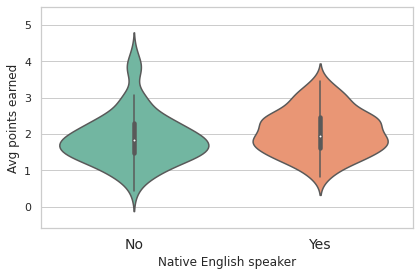

In [405]:
df_language=full_df_freq10.groupby(["username", "english"]).points.mean().reset_index()
df_language.rename({"english": "Native English speaker", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Native English speaker", y="Avg points earned", data=df_language)
plt.ylim([-0.6, 5.5])

###Mean points for users with familiarity in a given domain

(-0.6, 5.5)

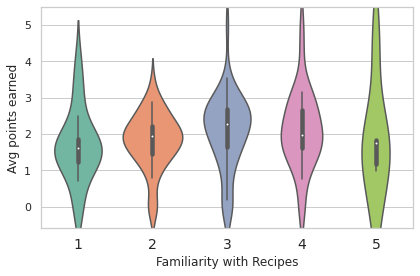

In [406]:
df_familiarity=full_df_freq20[full_df_freq20['dataset']=="Recipes"].groupby(["username", "recipe_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"recipe_familiarity": "Familiarity with Recipes", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with Recipes", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

(-0.6, 5.5)

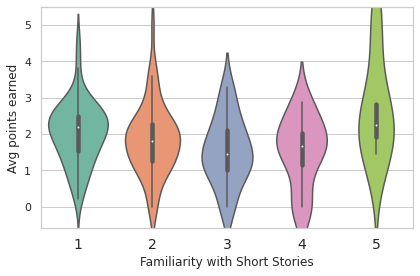

In [407]:
df_familiarity=full_df_freq20[full_df_freq20['dataset']=="Short Stories"].groupby(["username", "stories_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"stories_familiarity": "Familiarity with Short Stories", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with Short Stories", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

(-0.6, 5.5)

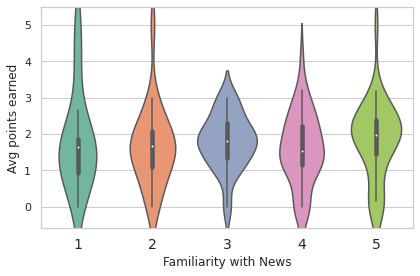

In [408]:
df_familiarity=full_df_freq20[full_df_freq20['dataset']=="New York Times"].groupby(["username", "news_familiarity"]).points.mean().reset_index()
df_familiarity.rename({"news_familiarity": "Familiarity with News", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Familiarity with News", y="Avg points earned", data=df_familiarity)
plt.ylim([-0.6, 5.5])

### Mean points for CIS majors vs. non-CIS majors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-0.6, 5.5)

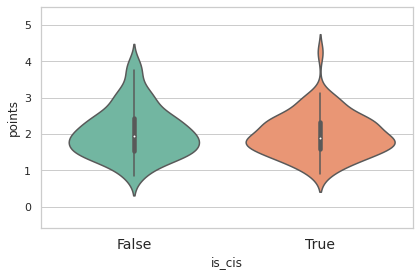

In [409]:
def is_cis_adjacent(x):
  cs_majors = ["CIS"]#, "MCIT", "CGGT", "CMPE", "ESE", "ROBO", "NETS", "DATS", "CBIO", "DMD", "SCMP"]
  return any([maj in list(x) for maj in cs_majors])
  
copied_df = full_df_freq20
copied_df['is_cis'] = full_df_freq20['major'].apply(is_cis_adjacent)
df_cis=copied_df.groupby(["username", "is_cis"]).points.mean().reset_index()
sns.violinplot(x="is_cis", y="points", data=df_cis)
plt.ylim([-0.6, 5.5])

### Mean points for those who read the guide and those who did not

(-0.6, 5.5)

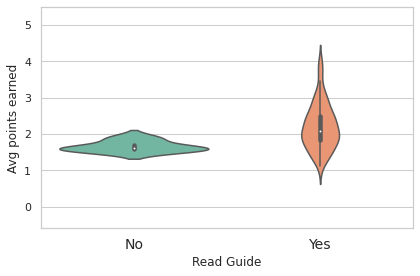

In [410]:
df_familiarity=full_df_freq20.groupby(["username", "read_guide"]).points.mean().reset_index()
df_familiarity.rename({"read_guide": "Read Guide", "points": "Avg points earned"}, axis=1, inplace=True)
sns.violinplot(x="Read Guide", y="Avg points earned", data=df_familiarity, order=["No", "Yes"])
plt.ylim([-0.6, 5.5])

## Reasoning behind annotation

We see that conditioning on grammar or generic-ness is least predictive. It's better to look for common sense, contradictions, or irrelevance. 

We also see that irrelevant makes up a very large percentage of all reported errors, suggesting that irrelevant generations are the biggest factor being picked up on by human annotators.

In [411]:
REASONS = ["grammar", "repetition", "irrelevant", "contradicts_sentence", "contradicts_knowledge", "common_sense", "coreference", "generic", "other"]

def is_reason(x, reason):
  return reason in list(x)
def is_other(x):
  return len(list(x)) != 0 and not any([r in list(x) for r in REASONS])

reason_df = copy.deepcopy(full_df)
#reason_df = reason_df[(reason_df["predicted_boundary_index"] >= reason_df["true_boundary_index"])]
for r in REASONS:
  reason_df[r] = full_df['reason'].apply(lambda x: is_reason(x, r))
reason_df["other"] = full_df['reason'].apply(is_other)

def analyze_per_reason():
  info_to_return = []
  for r in REASONS:
    df = reason_df[(reason_df[r]==True) & (reason_df["model"]!="easy") & (reason_df["model"]!="human") & (reason_df["model"]!="davinci")]
    
    if len(df) > 0:
      info = {"reason": r,
              "mean score": np.mean(df["points"]),
              "95% conf": mean_confidence_interval_me(df["points"]),
              #"median score": np.median(df["points"]),
              #"std dev": np.std(df["points"]), #TODO: switch to 95% confidence interval?
              #"fraction_nonzero": len(df[df["points"] > 0]) / len(df),
              "num_annotations": len(df)
      }
      info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_reason()

reason  mean score             95% conf  num_annotations
0                grammar    1.780377  (-0.10463, 0.10463)             1539
1             repetition    2.127747    (-0.1538, 0.1538)              728
2             irrelevant    2.530406  (-0.06402, 0.06402)             4259
3   contradicts_sentence    2.527397  (-0.10489, 0.10489)             1606
4  contradicts_knowledge    2.261517  (-0.11131, 0.11131)             1411
5           common_sense    2.566201  (-0.08611, 0.08611)             2432
6            coreference    2.249077  (-0.17626, 0.17626)              542
7                generic    1.920440  (-0.10078, 0.10078)             1546
8                  other    2.040000  (-0.48288, 0.48288)               75

In [412]:
def isin(x,y):
  return x in y

def print_random_example_reason(reason, df):
  filtered_df = df
  df["isreason"] = df["reason"].apply(lambda x: is_reason(x, reason))
  df = df[df["isreason"]==True]
  sampled = filtered_df.sample(n=1)
  sents = sampled['gen_body'].tolist()[0].split("_SEP_")
  for i, s in enumerate(sents):
    print(s)

print_random_example_reason("repetition", full_df)

"I laughed.
A little embarrassed by this comment (not really) but not so much because it was funny as that she had no idea how to respond or anything else at all - her expression didn
�t look like one anyone would have expected from someone who is very close to our protagonist...
Oh well if only for now we could get some rest here..
But then again perhaps those kind words weren` t usually reserved after their execution due entirely just before they were uttered without any sort  of background context
given us nothing more than an obvious request 'what do ya think?'
Well yes its nice seeing your hero give his assent while being insulted about something he did once enough time has passed when most people still see him take such seriously comments...
but remember i said `trust' instead :D
So rather way too hard on yourself apparently though
;)
In fact im
actually glad thats
over lol since obviously everyone likes getting offended everytime :)
If ole nihilo got annoyed back suddenly cannt 

In [413]:
def analyze_per_reason_model():
  info_to_return = []
  for r in REASONS:
    for model in set(full_df["model"].tolist()):
      df = reason_df[(reason_df[r]==True) & (reason_df["model"]==model)]
    
      if len(df) > 0:
        info = {"reason": r,
                "model": model,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df)
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_reason_model()

# TODO: When people correctly gave the answer as machine generated (any sentence from machine)

# model_names = set(full_df["model"].tolist())
#   model_names.remove('human')
#   for playlist in playlist_names:
#     for model in model_names:
#       for top_p_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#         df = full_df[(full_df["dec_strat_value"]==top_p_value) &
#                   (full_df["dataset"]==playlist) &
#                   (full_df["model"]==model)]

reason          model  mean score  median score  fraction_nonzero  \
0   grammar    ctrl-nocode    2.096774           2.0          0.524194   
1   grammar        davinci    2.500000           2.5          0.750000   
2   grammar  ctrl-Politics    1.718563           0.0          0.449102   
3   grammar      finetuned    1.384393           0.0          0.369942   
4   grammar        gpt2-xl    1.794915           0.0          0.494915   
..      ...            ...         ...           ...               ...   
66    other      finetuned    1.461538           0.0          0.384615   
67    other        gpt2-xl    1.812500           1.0          0.531250   
68    other           easy    0.000000           0.0          0.000000   
69    other          human    0.909091           0.0          0.181818   
70    other           gpt2    2.250000           2.0          0.500000   

    num_annotations  
0               124  
1                 4  
2               167  
3               346  
4               590  
..              ...  
66               13  
67               32  
68                1  
69               11  
70                4  

[71 rows x 6 columns]

In [414]:
def plot_boundary_distribution(dataset, ax, df, dataset_name, boundary_name):

  boundaries = df[df[dataset_name]==dataset][boundary_name].tolist()
  boundaries = collections.Counter(boundaries)

  if boundary_name == "num_sentences":
    data = [boundaries.get(i) for i in range(1,11)]
    labels = range(1,11)
  else:
    data = [boundaries.get(i) for i in range(10)]
    labels = range(10)

  ax.pie(data, labels=labels, autopct='%.0f%%')
  ax.set_title(map_playlist_name(dataset))



## Figure for reason analysis

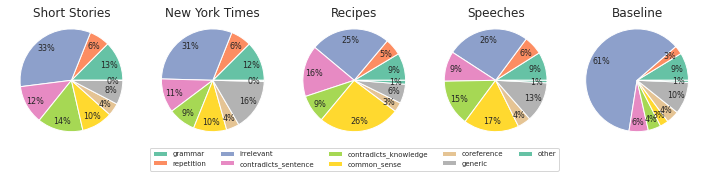

In [521]:
fig = plt.figure(figsize=[10, 2.5])
axes = fig.subplots(1, 5)

def plot_reasons_pie(df, ax, title):
  data = [df[r].sum() for r in REASONS]
  patches, texts, autotexts = ax.pie(data, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 8})
  ax.set_title(title, y=0.95)
  return patches
  
patches = plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='gpt2-xl')], axes[0], "Short Stories")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='gpt2-xl')], axes[1], "New York Times")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='gpt2-xl')], axes[2], "Recipes")
plot_reasons_pie(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='Presidential Speeches') & (reason_df['model']=='ctrl-nocode')], axes[3], "Speeches")
plot_reasons_pie(reason_df[(reason_df['model']=='easy')], axes[4], "Baseline")

fig.legend(patches, REASONS, loc="lower center", ncol=5, prop={'size':7})
plt.savefig("reasons_per_domain.pdf")

### Alternate style figure

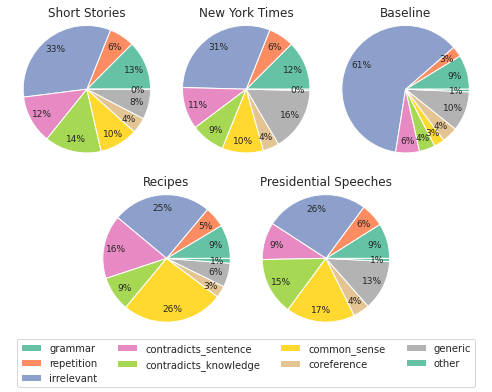

In [515]:
import matplotlib.gridspec as gridspec

REASONS = ["grammar", "repetition", "irrelevant", "contradicts_sentence", "contradicts_knowledge", "common_sense", "coreference", "generic", "other"]

def plot_reasons_pie_triangle(df, ax, title):
  data = [df[r].sum() for r in REASONS]
  patches, texts, autotexts = ax.pie(data, autopct='%.0f%%', pctdistance=0.8, textprops={'fontsize': 9})
  ax.set_title(title, y=0.92)
  return patches

fig = plt.figure(figsize=[7, 6])
gs = gridspec.GridSpec(nrows=3, ncols=6, wspace=0, hspace=0, height_ratios=[1,0.4,1])
fig.legend(patches,REASONS, loc="lower center", ncol=4, prop={'size':10})

plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Short Stories") & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[:2, :2]), "Short Stories")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=="Recipes") & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[1:, 1:3]), "Recipes")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='New York Times') & (reason_df['model']=='gpt2-xl')], fig.add_subplot(gs[:2, 2:4]), "New York Times")
plot_reasons_pie_triangle(reason_df[(reason_df['dec_strat_value']==0.4) & (reason_df['dataset']=='Presidential Speeches') & (reason_df['model']=='ctrl-nocode')], fig.add_subplot(gs[1:, 3:5]), "Presidential Speeches")
plot_reasons_pie_triangle(reason_df[(reason_df['model']=='easy')], fig.add_subplot(gs[:2, 4:]), "Baseline")

plt.savefig("reasons_per_model_new.pdf")

## Point Distributions

### Per playlist

In [424]:
import collections

In [425]:
df = full_df[full_df["model"].isin(('ctrl-Politics', 'ctrl-nocode', 'finetuned', 'gpt2-xl'))]
df = df[df["dec_strat_value"] == 0.4]

playlists = set(df["dataset"].tolist())
to_plot = []
for playlist in playlists:
  points = df[df["dataset"]==playlist].points.tolist()
  points = collections.Counter(points)

  heights = np.array(list(points.values())) / sum(points.values())
  for point_value, height in zip(points, heights):
    to_plot.append({"Points earned": point_value,
                    "Fraction of annotations":height,
                    "Domain": map_playlist_name(playlist)})

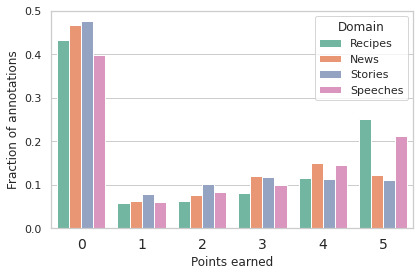

In [426]:
to_plot = pd.DataFrame(to_plot)
sns.barplot(x="Points earned", y="Fraction of annotations", hue="Domain", data=to_plot)
save("point_distribution.pdf")

### Per annotator

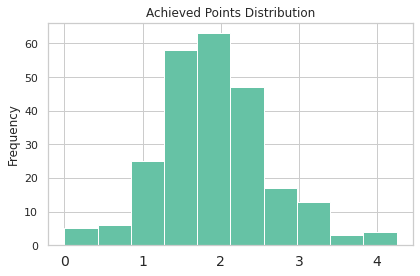

In [427]:
full_df.groupby('annotator').points.mean().plot.hist(
    title='Achieved Points Distribution'
)

## Find top annotators
These are annotators who got in the top quartile of annotators who did at least 10 annotations.

In [428]:
def find_top_annotators(df, min_n=10):
  """Analyze whether annotators improve in aggregate over k annotations."""
  
  annotators_and_points = []

  for annotator in set(df["annotator"].tolist()):
    points = df[df["annotator"] == annotator]["points"].tolist()
    
    if len(points) >= min_n:
      annotators_and_points.append((annotator, np.mean(points)))

  df = pd.DataFrame(annotators_and_points, columns=["annotator", "points"])
  quintile = np.quantile(df.points.tolist(), 0.75)
  print(quintile)
  df = df[df["points"] >= quintile]
  print(len(df))

  return df
top_annotators_df = find_top_annotators(full_df, 1)

2.3333333333333335
61


These are the annotators who did at least 50 annotations

In [429]:
def find_frequent_annotators(df, min_count):  
  annotators_and_points = []

  for annotator in set(df["annotator"].tolist()):
    points = df[df["annotator"] == annotator]["points"].tolist()
    
    if len(points) >= 20:
      annotators_and_points.append((annotator, np.mean(points), len(points)))

  df = pd.DataFrame(annotators_and_points, columns=["annotator", "points", "count"])
  print(len(df))

  return df
freq20_annotators_df = find_frequent_annotators(full_df, 20)
freq50_annotators_df = find_frequent_annotators(full_df, 50)

193
193


## Find bad annotators

In [430]:
full_df["predicted_boundary_index"]
full_df.groupby('annotator').sum()

generation  predicted_boundary_index  points   prompt  \
annotator                                                          
1661           605198                       135      52   441774   
1666           402845                        72      29   282655   
1682           101141                         7       6    64344   
1699          1484161                       553     128  1109441   
1700           122628                        50      28    85711   
...               ...                       ...     ...      ...   
5505          1747754                       512     262  1261044   
5506           757277                       219      80   540445   
5540          1838774                       763     176  1238811   
5560          1324568                       357     252   923538   
5582            76395                        50      11    53643   

           true_boundary_index  prompt_index  dec_strat_value  \
annotator                                                       
1661                       176         15390             13.6   
1666                        96        113031              6.8   
1682                        22         18643              2.4   
1699                       403        337404             33.6   
1700                        67         26670              5.0   
...                        ...           ...              ...   
5505                       507        369582             43.8   
5506                       190         64367             16.4   
5540                       513        210824             45.2   
5560                       405        117393             32.8   
5582                        26         19037              2.0   

           recipe_familiarity  news_familiarity  stories_familiarity  \
annotator                                                              
1661                      136               102                   68   
1666                       34                51                   85   
1682                       12                30                   24   
1699                      344               344                  344   
1700                       60                45                   30   
...                       ...               ...                  ...   
5505                      212               318                  424   
5506                      135               225                   90   
5540                      116               232                  116   
5560                      420               336                  252   
5582                       24                24                   24   

           gen_familiarity  isreason  
annotator                             
1661                    34         2  
1666                    34         1  
1682                     6         2  
1699                   172         1  
1700                    30         1  
...                    ...       ...  
5505                   106         3  
5506                    45         0  
5540                   116         2  
5560                    84         3  
5582                    12         1  

[241 rows x 12 columns]

In [431]:
def find_problematic_annotators(df):
  """Analyze whether annotators improve in aggregate over k annotations."""
  
  too_many_same_df = []

  for annotator in set(df["annotator"].tolist()):
    guesses = df[df["annotator"] == annotator]["predicted_boundary_index"].tolist()
    
    # Check of they almost always guessed the same boundary
    modal_guess = scipy.stats.mode(guesses)
    fraction_modal = modal_guess.count[0] / len(guesses)
    if fraction_modal > 0.9:
      too_many_same_df.append((annotator, modal_guess, fraction_modal, len(guesses)))

  return pd.DataFrame(
      too_many_same_df, columns=["annotator", "guess", "fractional_model", "num_annotations"])
df = find_problematic_annotators(full_df)
df

annotator       guess  fractional_model  num_annotations
0       2707  ([0], [1])               1.0                1

## Annotator performance over time

Of the annotators who did at least K annotations, plot their mean score over time

In [432]:
def analyze_progress(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  print(annotators)
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)
  return np.array(all_score_series), len(annotators)

In [433]:
def analyze_and_plot(s, n, k, title=''):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  # print("spearmanr: %.2f, %f" % stats.spearmanr(range(k), data))
  # print("pearsonr: %.2f, %f" % stats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Mean score")
  plt.xlabel("$n$th annotation")
  plt.title("Performance over time")
  if title:
    plt.savefig(title)
  plt.show()

### Analysis of annotators getting better over time (1st Batch)

**Conclusion**: We see no correlation on the first batch of annotators. They do not improve over time

[1699, 1734, 1766, 1784, 1802, 1815, 1820, 1844, 1849, 1894, 1953, 2024, 2089, 2171, 2174, 2255, 2271, 2577, 2664, 2683, 2764, 2932]
22


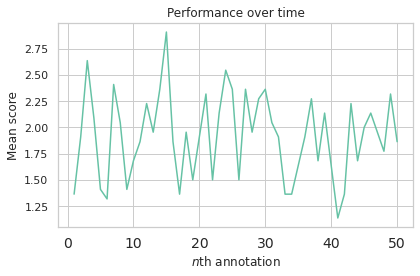

In [434]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

[1734, 1766, 1802, 1820, 1844, 1849, 2024, 2171, 2174, 2255, 2271, 2664, 2683]
13


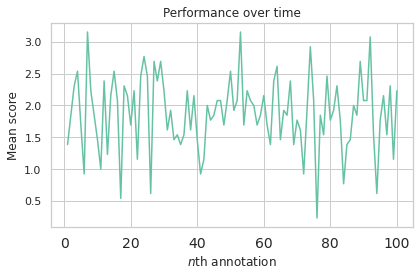

In [435]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k, "overtimeb1.pdf")

In [436]:
# s, n = analyze_progress(full_df[(full_df['date'] < '2021-10-1')].groupby('annotator').count(), k)
# analyze_and_plot(s, n, k, "overtimeb1.pdf")

### Analysis of annotators getting better over time (2nd Batch)

**Conclusion**: We actually see a positive correlation (over 0.3) for k=50, 100, and 200 on the second batch of annotators. They DO actually improve over time. This suggests that, with the correct instructions, annotators may be able to be taught how to improve at detecting generated text.

[2055, 2056, 4328, 4331, 4336, 4361, 4363, 4364, 4365, 4368, 4383, 4388, 4392, 4397, 4410, 4420, 4433, 4440, 4444, 4446, 4453, 4464, 4467, 4472, 4474, 4513, 4514, 4547, 4548, 4573, 4586, 4591, 4610, 4618, 4627, 4630, 4641, 4661, 4662, 4678, 4710, 4713, 4729, 4761, 4786, 4811, 4828, 4829, 4884, 4889, 4896, 4934, 4940, 4950, 4968, 4976, 4981, 4982, 5006, 5021, 5049, 5097, 5141, 5157, 5158, 5160, 5165, 5174, 5178, 5204, 5253, 5293, 5345, 5357, 5368, 5377, 5400, 5409, 5411, 5417, 5418, 5428, 5478, 5483, 5486, 5505, 5540, 5560]
88


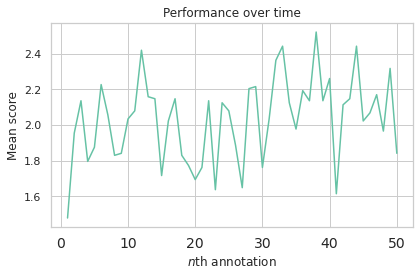

In [437]:
k = 50
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

[2055, 2056, 4328, 4331, 4361, 4363, 4364, 4365, 4368, 4388, 4397, 4410, 4433, 4440, 4444, 4446, 4453, 4467, 4472, 4474, 4513, 4514, 4547, 4548, 4573, 4586, 4591, 4610, 4618, 4627, 4630, 4641, 4661, 4662, 4678, 4710, 4713, 4729, 4761, 4786, 4811, 4828, 4829, 4884, 4889, 4896, 4934, 4940, 4950, 4968, 4976, 4981, 4982, 5006, 5021, 5049, 5097, 5141, 5157, 5158, 5165, 5174, 5178, 5204, 5253, 5293, 5345, 5357, 5368, 5377, 5400, 5409, 5411, 5417, 5418, 5428, 5478, 5483, 5486, 5505, 5540]
81


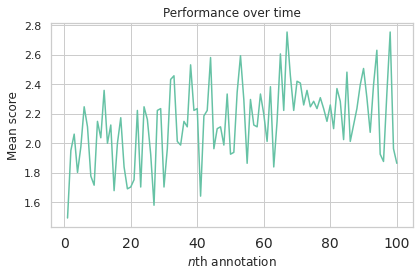

In [438]:
k = 100
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k, "overtimeb2.pdf")

[4331, 4361, 4388, 4410, 4472, 4573, 4586, 4641, 4678, 4710, 4761, 4811, 4940, 4982, 5141, 5204, 5293, 5345, 5428]
19


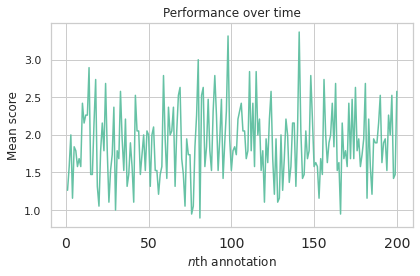

In [439]:
k = 200
s, n = analyze_progress(full_df[(full_df['date'] > '2021-10-1')].groupby('annotator').count(), k)
analyze_and_plot(s, n, k)

## Inter-annotator agreement

### Difference in abilities

In [440]:
def analyze_ability_differences(df, k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  df = df.groupby('annotator').count()
  all_score_series = []
  annotators = df[df["pk"] >= k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = full_df[full_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)
    
  return all_score_series

In [441]:
scores = analyze_ability_differences(full_df, 50)
sum_scores = [sum(s) for s in scores]

In [442]:
print("Mean score:", np.mean(sum_scores))
print("Std score:", np.std(sum_scores))

Mean score: 100.91891891891892
Std score: 27.129364807663663


In [443]:
df = full_df.groupby('annotator').count()
annotators = df[df["pk"] >= 50].reset_index()["annotator"].tolist()

df = full_df[full_df["annotator"].isin(annotators)]
df = df.groupby('annotator').sum()
# df = annotation_df.groupby('generation').boundary.apply(list).reset_index()
# df = df[df.apply(lambda row: len(row["boundary"]) >= 4, axis=1)]

### Fraction agreement
For every pair of annotators who annotated the same generaton, what fraction guessed the same boundary?

In [444]:
annotations_per_gen = annotation_df.groupby('generation')
num_annotations_per_gen = annotations_per_gen.points.count()

In [445]:
def analyze_fraction_agreements():
  generation_ids = set(full_df["generation"].tolist())
  annotations_per_gen = full_df.groupby('generation')

  overall_num_annotations = 0
  overall_num_agreements = 0

  x = annotations_per_gen.predicted_boundary_index.value_counts()
  for idx, generation in enumerate(generation_ids):
    chosen_boundaries = x[generation]
    chosen_boundaries = {k: chosen_boundaries[k] for k in chosen_boundaries.keys()}
    
    total_annotations = sum(chosen_boundaries.values())
    if total_annotations > 1:
      total_agreements = sum(v for v in chosen_boundaries.values() if v > 1)

      overall_num_annotations += total_annotations
      overall_num_agreements += total_agreements

  print("Out of {} total annotations on generations with >1 annotation, {} were in agreement with another annotation on the true boundary position. That is {}".format(
      overall_num_annotations, overall_num_agreements, overall_num_agreements/overall_num_annotations
  ))
analyze_fraction_agreements()

# TODO: Figure out what the baseline of random guessing would be,

Out of 20109 total annotations on generations with >1 annotation, 9191 were in agreement with another annotation on the true boundary position. That is 0.45705902829578793


### Krippendorf's Alpha

In [446]:
import nltk.metrics

In [447]:
from nltk.metrics.agreement import AnnotationTask

In [448]:
# Get all game rounds for which there were 4 or more annotations.
df = full_df.groupby('generation').predicted_boundary_index.apply(list).reset_index()
df = df[df.apply(lambda row: len(row["predicted_boundary_index"]) >= 4, axis=1)]

In [449]:
def build_annotation_task(df):
  annotation_data = []
  for idx, row in df.iterrows():
    coder = row["annotator"]
    item = row["generation"]
    label = row["predicted_boundary_index"]
    annotation_data.append((coder,item,label))
  ann_task = AnnotationTask(annotation_data)
  return ann_task

def build_binary_annotation_task(df):
  annotation_data = []
  for idx, row in df.iterrows():
    coder = row["annotator"]
    item = row["generation"]
    label = row["predicted_boundary_index"] >= row["true_boundary_index"]
    annotation_data.append((coder,item,label))
  ann_task = AnnotationTask(annotation_data)
  return ann_task

Main set of annotations we are using or analyses

In [450]:
print(len(full_df))
ann_task = build_binary_annotation_task(full_df)
print(ann_task.alpha())

21646
0.27038441521097156


Annotations before any filtering

In [451]:
print(len(full_df))
ann_task = build_binary_annotation_task(original_df)
print(ann_task.alpha())

21646
0.1987881681872522


Annotations excluding the ones for all human models

In [452]:
df = full_df[full_df["model"] != "human"]
print(len(df))
ann_task = build_binary_annotation_task(df)
print(ann_task.alpha())

19099
0.2543027424596338


Annotators who are in the top 25th percentile

In [453]:
df = full_df[full_df["annotator"].isin(top_annotators_df["annotator"])]
print(len(df))
ann_task = build_binary_annotation_task(df)
print(ann_task.alpha())

5444
0.26777133574092804


In [454]:
df = full_df[full_df["annotator"].isin(freq50_annotators_df["annotator"])]
print(len(df))
ann_task = build_binary_annotation_task(df)
print(ann_task.alpha())

top_annotators_df

21024
0.2707865573508659


annotator    points
0         4610  2.469388
1         2055  2.405405
2         2056  2.986111
5         4627  2.843931
7         4630  2.437186
..         ...       ...
222       5068  2.772727
223       4558  2.766667
232       4586  2.492537
233       2027  3.300000
234       4591  3.747826

[61 rows x 2 columns]

## Profile Statistics

In [455]:
def user_stats(df, name):
  data = {"name": name}
  data["num_participants"] = len(np.unique(df["annotator"]).tolist())
  data["num_annotations"] = len(df)
  data["mean_annotations_per_participant"] = data["num_annotations"] / data["num_participants"] 
  data["mean_points"] = np.mean(df["points"])
  data["std_points"] = np.std(df["points"])
  return data

In [456]:
all_data = []
all_data.append(user_stats(full_df, "overall"))
all_data.append(user_stats(full_df[(full_df['date'] <= '2021-10-1')], "Section A"))
all_data.append(user_stats(full_df[(full_df['date'] > '2021-10-1')], "Section B"))

In [457]:
pd.DataFrame(all_data)

name  num_participants  num_annotations  \
0    overall               241            21646   
1  Section A               141             6527   
2  Section B               102            15119   

   mean_annotations_per_participant  mean_points  std_points  
0                         89.817427     2.083249    2.124356  
1                         46.290780     1.966294    2.124174  
2                        148.225490     2.133739    2.122444

# Time Tracking Analysis
TODO: double check that timestamps are properly merged with the correct annotations. Also find a better way to calculate time delta than shift down by 1 and filter.

In [458]:
timing_df = get_df('core.timestamp')
timing_df = timing_df.rename(columns={'date': 'timestamp'}).merge(full_df, left_on='annotation', right_on='pk')

In [459]:
timing_df['timestamp'] = pd.to_datetime(timing_df.timestamp)
timing_df['delta'] = timing_df.timestamp - timing_df.timestamp.shift(1)
timing_df['delta'] = timing_df.delta.dt.components.milliseconds / 1000.0 + timing_df.delta.dt.components.seconds + timing_df.delta.dt.components.minutes * 60.0
# timing_df["delta"] = timing_df[timing_df.delta < 120] # TODO: Do this more properly instead of shift and filter

In [460]:
timing_df['delta']

0           NaN
1         2.628
2         1.243
3         0.808
4         0.714
          ...  
117681    0.783
117682    1.065
117683    1.006
117684    0.837
117685    1.025
Name: delta, Length: 117686, dtype: float64

## Median Time Delta

In [461]:
timing_df.delta.median()

3.208

In [462]:
print(timing_df[timing_df['date'] <= '2021-10-1'].delta.mean())
print(timing_df[timing_df['date'] <= '2021-10-1'].delta.std())
print(timing_df[timing_df['date'] > '2021-10-1'].delta.mean())
print(timing_df[timing_df['date'] > '2021-10-1'].delta.std())
print(timing_df.delta.mean())
print(timing_df.delta.std())

89.31065153406479
519.7383737839745
206.1812961723142
808.5885368676497
191.06562227981473
778.2839526095828


## Correlation Between Time Delta and Decoding Hyperparameter (top-p)

In [463]:
timing_df[['dec_strat_value', 'delta']].corr()

dec_strat_value    delta
dec_strat_value          1.00000 -0.00472
delta                   -0.00472  1.00000

## Time Delta Distribution

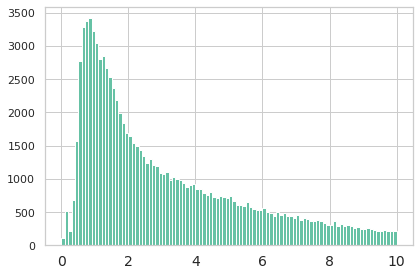

In [464]:
timing_df.delta.hist(bins=100, range=(0,10))
#plot( kind='hist',    range=(0, 60),    bins=30,    figsize=(20, 10),    title=('Turn Duration Distribution (seconds)')  )

## Correlation Between Time Delta and Sentence Length

In [465]:
timing_df['gen_body_length'] = timing_df.gen_body.str.len()
timing_df.groupby('annotation').agg({'delta': 'sum', 'gen_body_length': 'mean'}).corr()

delta  gen_body_length
delta            1.000000        -0.034415
gen_body_length -0.034415         1.000000

## Correlation Between Time Delta and Points

In [466]:
timing_df.groupby('annotation').agg({'delta': 'sum', 'points': 'mean'}).corr()

delta    points
delta   1.000000  0.084621
points  0.084621  1.000000

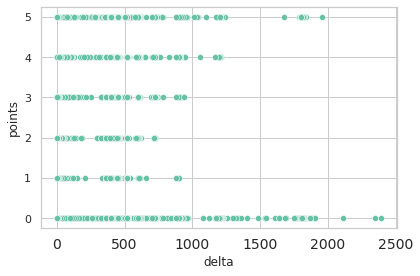

In [467]:
df_to_plot = timing_df.groupby('annotation').agg({'delta': 'mean', 'points':'mean'})
sns.scatterplot(y='points', x='delta', data=df_to_plot)

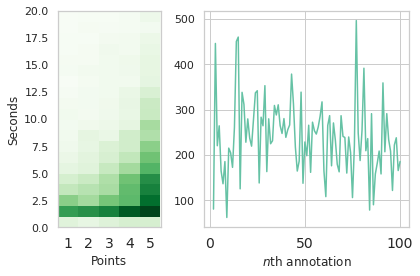

In [468]:
def analyze_and_plot_speed(s, n, k, title=''):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  print("spearmanr: %.2f, %f" % stats.spearmanr(range(k), data))
  print("pearsonr: %.2f, %f" % stats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Avg Time / Annotation")
  plt.xlabel("$n$th annotation")
  plt.title("Speed over time")
  if title:
    plt.savefig(title)
  plt.show()

def analyze_speed(df, k=50):
  """Analyze whether annotators get faster in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["model"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = timing_df[timing_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["delta"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

fig = plt.figure(figsize=[6, 4])
fig.tight_layout(pad=0)
width_ratios = [0.33, 0.66]
axes = fig.subplots(1, len(width_ratios), gridspec_kw={'width_ratios': width_ratios})

s,n = analyze_speed(timing_df.groupby('annotator').count(), 100)
axes[1].plot(range(1, 101), np.mean(np.array(s), axis=0))

df_to_plot = timing_df.groupby('annotation').agg({'delta': 'mean', 'points':'mean'})
axes[0].hist2d(df_to_plot['points'], df_to_plot['delta'], bins=[np.arange(1,8) - 0.5,20], range=[[1,5],[0,20]], cmap="Greens")
axes[0].set_xticks(range(6))
axes[0].set_xlim([0.5, 5.5])
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Seconds')
axes[1].set_xlabel('$n$th annotation')

plt.savefig("time_tracking.pdf")
plt.show()

In [469]:
timing_df.groupby('annotation').agg({'delta': 'mean', 'points':'mean'})

delta  points
annotation                   
9735         1.044500     1.0
9737         1.439100     0.0
9739         5.886000     0.0
9749        38.533667     0.0
9754        14.772500     0.0
...               ...     ...
51452        1.398400     5.0
51459       11.975778     0.0
51460        1.441667     0.0
51461        1.274111     0.0
51462        1.415889     5.0

[17451 rows x 2 columns]

## Comparison of Average Time Deltas Between Text Domains

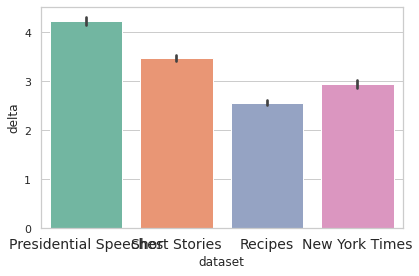

In [470]:
# Median
sns.barplot(y='delta', x='dataset', data=timing_df, estimator=np.median)#.groupby('dataset').agg({'delta': 'median'}).plot.bar()

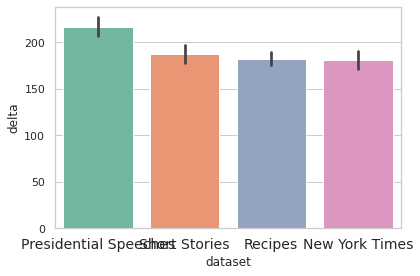

In [471]:
# Mean
sns.barplot(y='delta', x='dataset', data=timing_df)

## Comparison of Average Time Deltas Between Models

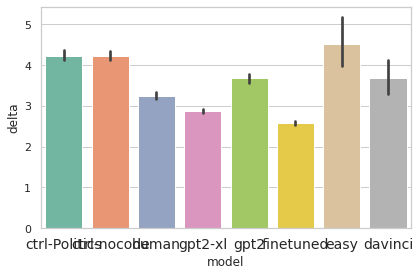

In [472]:
# Median
sns.barplot(y='delta', x='model', data=timing_df, estimator=np.median)

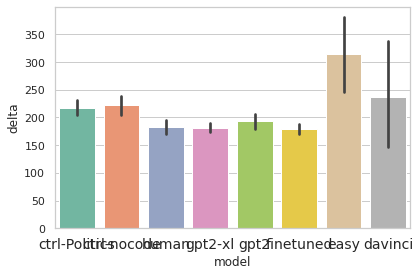

In [473]:
# Mean
sns.barplot(y='delta', x='model', data=timing_df)

## Do annotators get faster or slower over time?



142


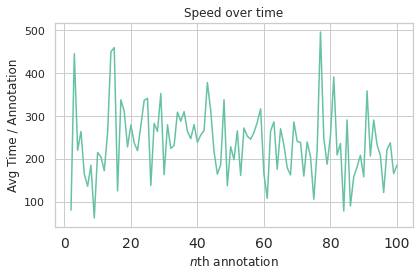

In [474]:
def analyze_and_plot_speed(s, n, k, title=''):
  print(n)
  data = np.array(s)
  data = np.mean(data, axis=0)
  # print("spearmanr: %.2f, %f" % stats.spearmanr(range(k), data))
  # print("pearsonr: %.2f, %f" % stats.pearsonr(range(k), data))
  plt.plot(range(1, k+1), data)
  plt.ylabel("Avg Time / Annotation")
  plt.xlabel("$n$th annotation")
  plt.title("Speed over time")
  if title:
    plt.savefig(title)
  plt.show()

def analyze_speed(df, k=50):
  """Analyze whether annotators get faster in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["model"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = timing_df[timing_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["delta"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series), len(annotators)

s,n = analyze_speed(timing_df.groupby('annotator').count(), 100)
analyze_and_plot_speed(s, n, 100)